# Facilitated Machine Learning Models for Karyotyping in the Patients with Chromosomal Abnormalities: Retrospective Study

- **Chuan Yang**, MD, PhD Student
- Mentor: **Yanyan Zhao**, MD, PhD
- Shengjing Hospital of China Medical University

# Chr 09 vs Chr 09 Inversion

# 0. Modules

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sb

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import KFold

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow import keras

from os import walk

import time
import datetime

%matplotlib inline

# 1. Samples


## 1.1. Chormosome Label Convert by using Dictionary

In [2]:
chromConvert = {
               'chr_09': 0, 
               'chr_9_inversion': 1
               }

In [3]:
chromConvert_reverse = {
                0: 'chr_09',
                1: 'chr_9_inversion'
               }

## 1.2. File Import

### 1.2.1. Filename Assignments

In [4]:
# pathBase = 'C:\\Users\\Chuan\\OneDrive\\Dowrun\\Database\\PhD\\KaryoTypes\\Arrangement\\'
# pathBase = 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement\\'
# pathBase = 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement\\'
# ///////////////////////////////////////////////
# Merged Database
pathBase = 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\'

#pathBase = 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\'

theWhole = {}
        
f = []
f_09 = []
mypath_09 = pathBase + 'chr_09'
for (dirpath, dirnames, filenames) in walk(mypath_09):
    f.extend(filenames)
for l in f:
    f_09.append(mypath_09 + '\\' + l)    
    
# ///////// Abnormal ones //////////////

f = []
f_9_inversion = []
mypath_9_inversion = pathBase + 'chr_9_inversion'
for (dirpath, dirnames, filenames) in walk(mypath_9_inversion):
    f.extend(filenames)
for l in f:
    f_9_inversion.append(mypath_9_inversion + '\\' + l)  
    
theWhole['chr_09'] = f_09
theWhole['chr_9_inversion'] = f_9_inversion


In [5]:
theWhole['chr_9_inversion']

['D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_9_inversion\\182433_9p12q-10R.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_9_inversion\\182433_9p12q-11R.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_9_inversion\\182433_9p12q-12R.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_9_inversion\\182433_9p12q-13R.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_9_inversion\\182433_9p12q-14R.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_9_inversion\\182433_9p12q-15R.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_9_inversion\\182433_9p12q-17R.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_9_inversion\\182433_9p12q-18R.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_9_inversion\\182433

In [6]:
type(theWhole['chr_09'])

list

In [7]:
len(theWhole)

2

In [8]:
type(theWhole)

dict

In [9]:
theWhole.keys()

dict_keys(['chr_09', 'chr_9_inversion'])

### 1.2.2. Helper Functions

In [10]:
def extractData(image):
    x = image.size[0]
    y = image.size[1]
    
    matrix = []
    rgb_matrix = []

    for i in range(x):
        matrix.append([])
        rgb_matrix.append([])
        
        for j in range(y):
            r, g, b = image.getpixel((j, i))            
            value = r * 299.0/1000 + g * 587.0/1000 + b * 114.0/1000
            value = int(value)
            matrix[i].append(value)
            rgb_matrix[i].append((r,g,b))
    return matrix, rgb_matrix

In [11]:
def imageReconstruct(matrix):
    df = np.array(matrix, dtype=np.uint8)
    img = Image.fromarray(df, 'RGB')
    img.save('image.png')
    return img

# 2. Cross Validation

## 2.1. KFold

- Let's say split every class into 7 folds

In [12]:
kfold = KFold(7, True, 1)

# 分成7个子集，每次6个子集用于训练，1个子集用于测试
# 每种分法进行一次训练和测试的迭代，总共8次迭代。

## 2.2. Assignment of filename which has been splitted randomly

In [13]:
X_train_name = {}
X_test_name = {}

# 赋值两个接收文件路径的dictionary，其第一个key值为染色体或异常核型的名称，第二个为交叉验证（迭代）的序号

for chrNo in theWhole.keys():

    X_train_name[chrNo] = {}
    X_test_name[chrNo] = {}
    
    # chrNo为染色体号或异常核型号，在此内部再定义迭代次数

    split_method_number = 0
    
    # 赋值每次split分法的序号值

    generator_kFold = kfold.split(theWhole[chrNo])
    
    # 依染色体或异常核型的类型进行split，因为每个类别的样本量不均衡，以每个类别进行split
    # 赋值一个generator对象，以下对generator进行迭代。
    
    print('Chromosome/Abnormality: ', chrNo)

    for train, test in generator_kFold:    
        
        # 循环产生train和test集

        print('Split Method No. ', split_method_number)

        print('Train: ', train, 'Test: ', test, '\n')

        # train和test的值是7个split分法的每个分法的list

        X_train_name[chrNo][split_method_number] = []
        X_test_name[chrNo][split_method_number] = []




        for split_method_train in train:
            
            # train 为训练集list中的序号值

            # split_method_train的值是每个split方法，其值为图像序号
            
            X_train_name[chrNo][split_method_number].append(theWhole[chrNo][split_method_train])
            
            # 将训练集那个序号的图像的文件path和文件名赋值给X_train_name这个二维dictionary


        for split_method_test in test:

            # split_method_test的值是每个split方法，其值为图像序号
            
            X_test_name[chrNo][split_method_number].append(theWhole[chrNo][split_method_test])
            
            # 同样将测试集的路径和文件名赋值给X_test_name

        split_method_number = split_method_number + 1
        
        # Split分法序号自加

Chromosome/Abnormality:  chr_09
Split Method No.  0
Train:  [  0   1   2   3   5   7   8   9  10  13  14  15  16  17  19  20  21  22
  23  24  25  26  28  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  86  87  88  93  94  95  96  97  98  99 100 101 103 104
 105 108 109 110 111 112 113 114 115 116 117 118 119 121 122 123 124 126
 127 128 129 130 131 132 133 134 135 136 137 138 140 141 142 143 144 145
 146 148 149 150 151 152 153 155 156 157 158 160 161 162 164 165 166 167
 168 169 170 171 173 174 175 176 177 178 179 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 206
 207 208 209 210 211 213 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 234 235 236 237 238 239 240 241 242 243 244 245 246
 248 249 250 252 253 254 255 256 257 258 259 263 264 265 266 267

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guid

In [14]:
len(X_train_name['chr_09'])

7

In [15]:
len(X_train_name['chr_09'][0])

282

In [16]:
len(X_test_name['chr_09'][0])

47

In [17]:
X_train_name['chr_09'][1] # 表示第一轮split的方法的1号染色体的训练样本的文件名

['D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-11L.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-12L.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-13L.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-14L.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-15L.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-17L.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-18L.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-19L.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-20L.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement

In [18]:
X_test_name['chr_09'][1]

['D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-10L.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-1L.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-3L.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-5L.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\184431-_9p12q13_4L.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\184431-_9p12q13_6L.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\193002-9p12q13_18L.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\193002-9p12q13_9L.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\193067-9p12q_12L.bmp',
 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrange

In [19]:
X_train_name

{'chr_09': {0: ['D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-10L.bmp',
   'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-11L.bmp',
   'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-12L.bmp',
   'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-13L.bmp',
   'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-15L.bmp',
   'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-18L.bmp',
   'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-19L.bmp',
   'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-1L.bmp',
   'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\chr_09\\182433_9p12q-20L.bmp',
   'D:\\Users\\Chuan\\Documents\\D

# Iteration Starts Here:

###  Performance variables defined for iterations

In [20]:
iterationNumber = 0
accuracies = {}
performanceReport = {}
auc_value_dict = {}

# 3. Iteration 0

## 3.1 Image Input

### 3.1.x Display the Split Method

In [21]:
print('Iteration No. ', iterationNumber)


for chrNo in theWhole.keys():
    print(chrNo)
    print('   Train: ')
    for item in X_train_name[chrNo][iterationNumber]:
        print('       ', item.split('\\')[-1])
    print('   Test: ')
    for item in X_test_name[chrNo][iterationNumber]:
        print('       ', item.split('\\')[-1])

Iteration No.  0
chr_09
   Train: 
        182433_9p12q-10L.bmp
        182433_9p12q-11L.bmp
        182433_9p12q-12L.bmp
        182433_9p12q-13L.bmp
        182433_9p12q-15L.bmp
        182433_9p12q-18L.bmp
        182433_9p12q-19L.bmp
        182433_9p12q-1L.bmp
        182433_9p12q-20L.bmp
        182433_9p12q-2L.bmp
        182433_9p12q-3L.bmp
        182433_9p12q-4L.bmp
        182433_9p12q-5L.bmp
        182433_9p12q-6L.bmp
        182433_9p12q-8L.bmp
        182433_9p12q-9L.bmp
        184431-_9p12q13_10L.bmp
        184431-_9p12q13_11L.bmp
        184431-_9p12q13_12L.bmp
        184431-_9p12q13_13L.bmp
        184431-_9p12q13_14L.bmp
        184431-_9p12q13_15L.bmp
        184431-_9p12q13_18L.bmp
        184431-_9p12q13_1L.bmp
        184431-_9p12q13_20L.bmp
        184431-_9p12q13_21L.bmp
        184431-_9p12q13_22L.bmp
        184431-_9p12q13_23L.bmp
        184431-_9p12q13_24L.bmp
        184431-_9p12q13_26L.bmp
        184431-_9p12q13_2L.bmp
        184431-_9p12q13_3L.bmp


### 3.1.2. Assignment of Training Data

#### 3.1.2.1 Training: Image Object Assignment

In [22]:
image = {}

# 定义容纳图片对象的dictionary类型的变量image

i = 0

for chrNo in theWhole.keys():
    image[chrNo] = []
    for case in X_train_name[chrNo][iterationNumber]:
        
        # 上面一行第二个中括号内为split的序号，0为第0次split分法
        
        img = Image.open(case)
        image[chrNo].append(img)
        
        # image字典接受的是图片对象

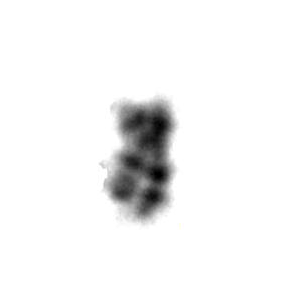

In [23]:
image['chr_09'][1] # 测试一下图像对象

#### 3.1.2.2. Training: Data Extraction from Images

#### - Training Set Data: 将图像对象转变为矩阵数值

In [24]:
data = {}
#rgb_data = {}

for chrNo in image.keys():
    data[chrNo] = []; 
    #rgb_data[chrNo] = []
    for case in image[chrNo]:
        grey, rgb = extractData(case)
        data[chrNo].append(grey)
        #rgb_data[chrNo].append(rgb)

In [25]:
array = {}

for chrNo in data.keys():
    array[chrNo] = []
    for case in data[chrNo]:            
        array[chrNo].append(case)

x_train_list = []
y_train_list = []

for y, x in array.items():    
    for x_item in x:
        x_train_list.append(x_item)
        y_train_list.append(y)
        
        # 将图像数据赋值给x_train_list;
        # 将标签数据赋值给y_train_list.

### 3.1.3. Assignment of Testing Data

#### 3.1.3.1. Testing: Image Object Assignment

In [26]:
# 方法同前面的Training Set

image = {}
i = 0

for chrNo in theWhole.keys():
    image[chrNo] = []
    for case in X_test_name[chrNo][iterationNumber]: # Change here for different iterations!!!!!
        
        # 上面一行第二个中括号内为split的序号，0为第0次split分法
        
        img = Image.open(case)
        image[chrNo].append(img)

#### 3.1.3.2. Testing: Data Extraction from Images

In [27]:
data = {}
#rgb_data = {}

for chrNo in image.keys():
    data[chrNo] = []; 
    #rgb_data[chrNo] = []
    for case in image[chrNo]:
        grey, rgb = extractData(case)
        data[chrNo].append(grey)
        #rgb_data[chrNo].append(rgb)

In [28]:
array = {}

for chrNo in data.keys():
    array[chrNo] = []
    for case in data[chrNo]:            
        array[chrNo].append(case)

x_test_list = []
y_test_list = []

for y, x in array.items():    
    for x_item in x:
        x_test_list.append(x_item)
        y_test_list.append(y)

### 3.1.4. ChromConvert

In [29]:
# 将染色体序号和异常核型名称更换为序号，序号定义在程序开始部分

y_train_digital_list = []
for item in y_train_list:
    y_train_digital_list.append(chromConvert[item])
    
y_test_digital_list = []
for item in y_test_list:
    y_test_digital_list.append(chromConvert[item])

### 3.1.5. Change to Numpy Array

In [30]:
X_train = np.array(x_train_list)
y_train = np.array(y_train_digital_list)

In [31]:
X_test = np.array(x_test_list)
y_test = np.array(y_test_digital_list)

In [32]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [33]:
len(X_train)

488

In [34]:
X_train[0].shape

(300, 300)

## 3.2. Convolutional Neural Network

### 3.2.1 Data Preparation

In [35]:
X_train = X_train.reshape(-1, 300, 300, 1)
X_test = X_test.reshape(-1, 300, 300, 1)

### 3.2.3 Training Model Design

In [36]:
model = Sequential()

In [37]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

In [38]:
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(600, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

### 3.2.4. Tensorboard Initilization

In [39]:
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### 3.2.5. Compile the modal

In [40]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### 3.2.6. Fitting (拟合)

In [41]:
model.fit(X_train, y_train, epochs=80, batch_size=64, verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback])

Epoch 1/80
8/8 [==============================] - 6s 442ms/step - loss: 51.4031 - accuracy: 0.5369 - val_loss: 6.3244 - val_accuracy: 0.4268
Epoch 2/80
8/8 [==============================] - 1s 124ms/step - loss: 1.6717 - accuracy: 0.5041 - val_loss: 0.6911 - val_accuracy: 0.5732
Epoch 3/80
8/8 [==============================] - 1s 121ms/step - loss: 0.6885 - accuracy: 0.5758 - val_loss: 0.6938 - val_accuracy: 0.5732
Epoch 4/80
8/8 [==============================] - 1s 119ms/step - loss: 1.1597 - accuracy: 0.6168 - val_loss: 0.6885 - val_accuracy: 0.5244
Epoch 5/80
8/8 [==============================] - 1s 130ms/step - loss: 0.6837 - accuracy: 0.6107 - val_loss: 0.6708 - val_accuracy: 0.7683
Epoch 6/80
8/8 [==============================] - 1s 122ms/step - loss: 0.7162 - accuracy: 0.7582 - val_loss: 0.5275 - val_accuracy: 0.7683
Epoch 7/80
8/8 [==============================] - 1s 120ms/step - loss: 0.6039 - accuracy: 0.8012 - val_loss: 0.6347 - val_accuracy: 0.7195
Epoch 8/80
8/8 [===

8/8 [==============================] - 1s 123ms/step - loss: 1.8639e-07 - accuracy: 1.0000 - val_loss: 2.9635 - val_accuracy: 0.9390
Epoch 59/80
8/8 [==============================] - 1s 122ms/step - loss: 1.7002e-07 - accuracy: 1.0000 - val_loss: 2.9930 - val_accuracy: 0.9390
Epoch 60/80
8/8 [==============================] - 1s 122ms/step - loss: 1.5365e-07 - accuracy: 1.0000 - val_loss: 3.0207 - val_accuracy: 0.9390
Epoch 61/80
8/8 [==============================] - 1s 122ms/step - loss: 1.4168e-07 - accuracy: 1.0000 - val_loss: 3.0451 - val_accuracy: 0.9390
Epoch 62/80
8/8 [==============================] - 1s 120ms/step - loss: 1.3191e-07 - accuracy: 1.0000 - val_loss: 3.0710 - val_accuracy: 0.9390
Epoch 63/80
8/8 [==============================] - 1s 121ms/step - loss: 1.2165e-07 - accuracy: 1.0000 - val_loss: 3.0902 - val_accuracy: 0.9390
Epoch 64/80
8/8 [==============================] - 1s 120ms/step - loss: 1.1261e-07 - accuracy: 1.0000 - val_loss: 3.1153 - val_accuracy: 0.93

### 3.2.7 Summary

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 322624)            0         
_________________________________________________________________
dense (Dense)                (None, 300)               9

### 3.2.8. Tensorboard Display

In [43]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 19276), started 11 days, 5:54:41 ago. (Use '!kill 19276' to kill it.)

## 3.8 Save the Model

In [44]:
model.save('saved_model/model_Chr_09_cnn_iteration_'+str(iterationNumber))

INFO:tensorflow:Assets written to: saved_model/model_Chr_09_cnn_iteration_0\assets


## 3.9 Load the Model

In [45]:
model_reload = keras.models.load_model('saved_model/model_Chr_09_cnn_iteration_'+str(iterationNumber))

## 3.10. Performance Measures

### 3.10.1. Accuracy

In [46]:
loss, acc = model_reload.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)
accuracies[iterationNumber] = acc

Test Accuracy: 0.939


In [47]:
len(X_test)

82

In [48]:
y_predict = model_reload.predict(X_test)

In [49]:
len(y_predict)

82

In [50]:
# The number 32 means the type number of all chromosome class number inlcuding abnormal ones
y_predict_filtered = []

for sample in y_predict:
    maximum = 0
    indicator = 0
    for i in range(2):
        if sample[i] > maximum:
            maximum = sample[i]
            indicator = i
    y_predict_filtered.append(indicator)        

In [51]:
label = ['chr_09', 'chr_9_inversion']

label_convert = []

for i in range(2):
    label_convert.append(chromConvert_reverse[i])

### 3.10.2. Classification Report

In [52]:
performanceReport[iterationNumber] = classification_report(y_test, y_predict_filtered, target_names=label_convert)

# Change here for different iteration!!!!!

print(performanceReport[iterationNumber])

                 precision    recall  f1-score   support

         chr_09       0.90      1.00      0.95        47
chr_9_inversion       1.00      0.86      0.92        35

      micro avg       0.94      0.94      0.94        82
      macro avg       0.95      0.93      0.94        82
   weighted avg       0.94      0.94      0.94        82



### 3.10.3. Confusion Matrix

In [53]:
cm = np.array(confusion_matrix(y_test, y_predict_filtered, labels=[0, 1]))
confusion = pd.DataFrame(cm, index=label_convert,
                        columns=label_convert)
confusion.to_csv('ConfusionMatrix_Chr_09_KaryoType_CNN' + str(iterationNumber) + '.csv')
confusion

,chr_09,chr_9_inversion
chr_09,47,0
chr_9_inversion,5,30


#### Heat Map

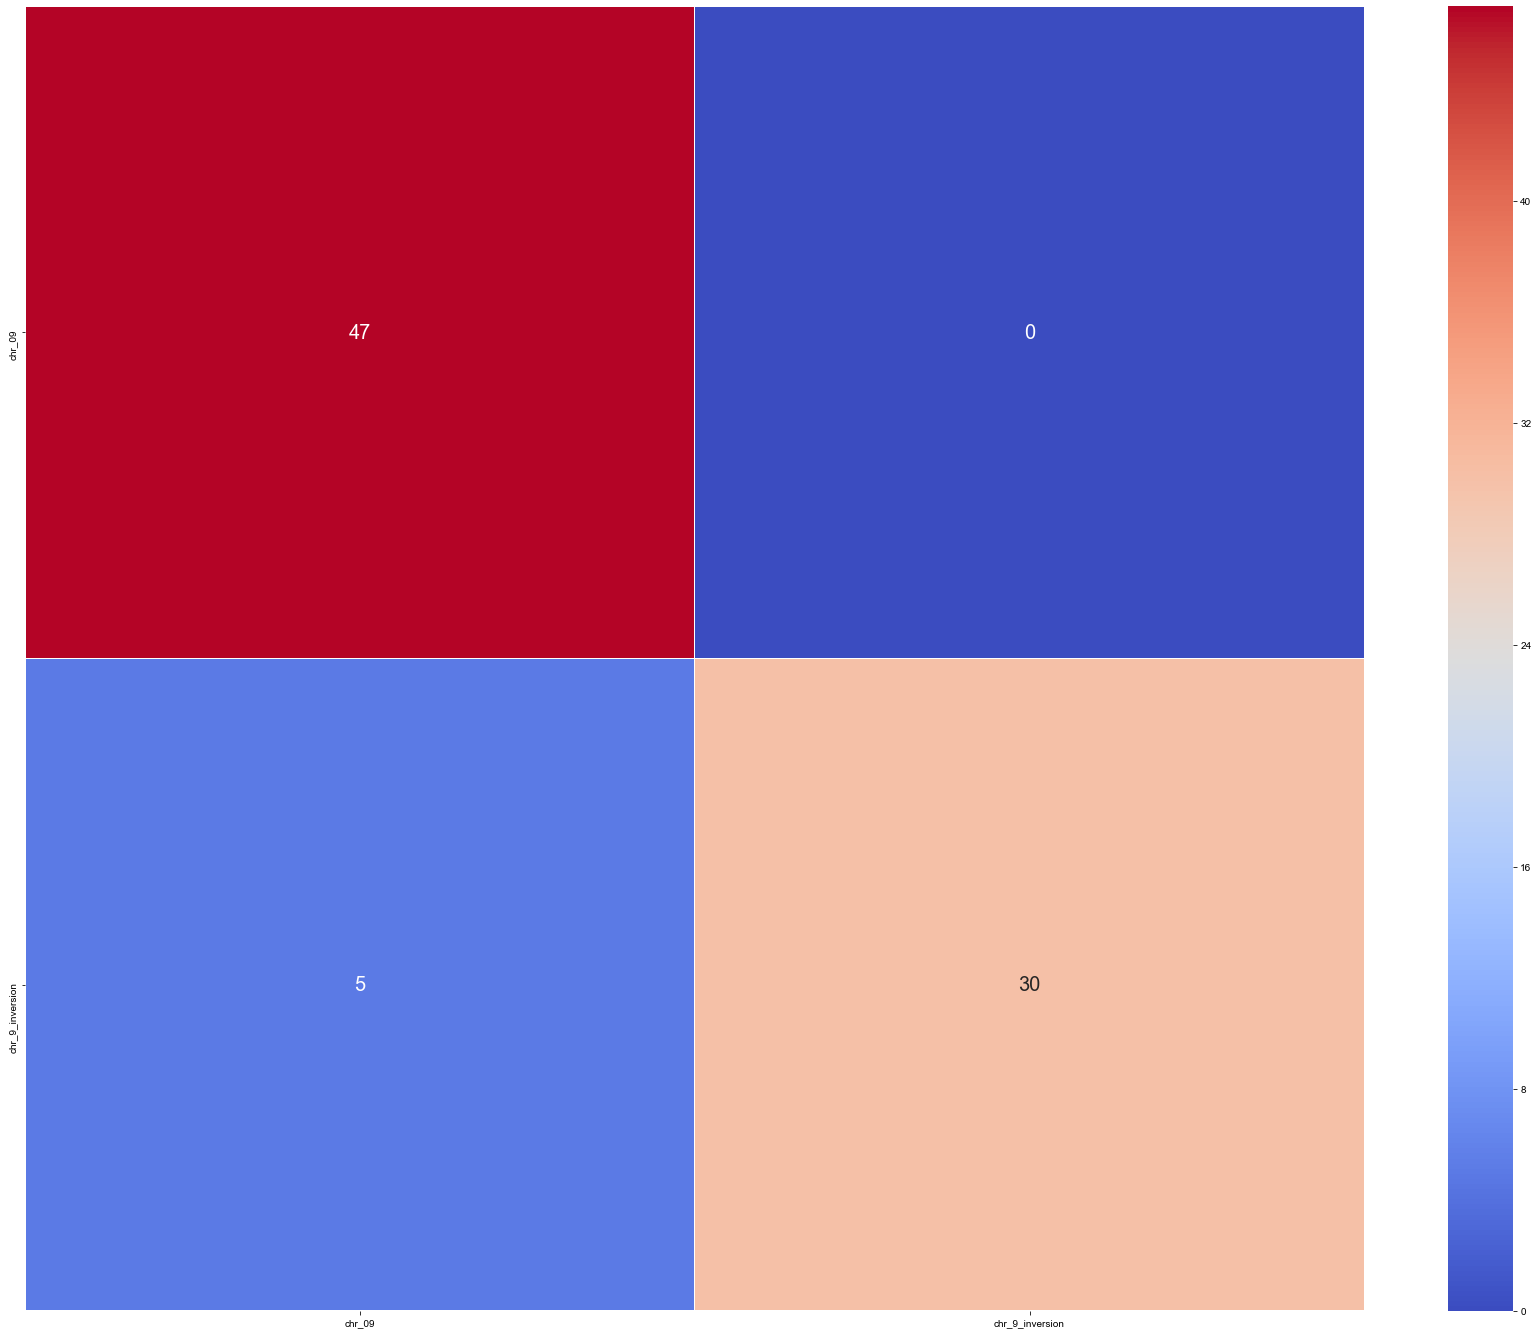

In [54]:
plt.figure(figsize=(30, 24))
heat_map = sb.heatmap(confusion, annot=True,  # It's a Seaborn function
                      cmap='coolwarm', 
                      xticklabels=confusion.columns, yticklabels=confusion.index, 
                      linewidths=.5, 
                      annot_kws={"size": 20})
sb.set(font_scale = 2)

In [55]:
fig = heat_map.get_figure()    
fig.savefig('Heatmap_Chr_09_Iteration_' + str(iterationNumber) + '.png', dpi=400)

### 3.10.4. ROC

In [56]:
y_predict

array([[1.00000000e+00, 5.25047810e-08],
       [9.99999881e-01, 4.35099937e-04],
       [9.85598147e-01, 8.35631639e-02],
       [1.00000000e+00, 4.35811398e-06],
       [1.00000000e+00, 1.31307877e-06],
       [1.00000000e+00, 1.19592114e-05],
       [1.00000000e+00, 1.70429117e-16],
       [1.00000000e+00, 4.20142632e-09],
       [9.99999762e-01, 1.07636023e-03],
       [1.00000000e+00, 1.95070311e-15],
       [1.00000000e+00, 7.22372251e-09],
       [1.00000000e+00, 8.60656693e-14],
       [1.00000000e+00, 7.82832978e-18],
       [1.00000000e+00, 6.19525681e-11],
       [1.00000000e+00, 9.54351487e-10],
       [1.00000000e+00, 7.17344317e-09],
       [1.00000000e+00, 9.21835407e-20],
       [1.00000000e+00, 8.08478617e-09],
       [1.00000000e+00, 1.98618054e-07],
       [1.00000000e+00, 1.16802928e-10],
       [1.00000000e+00, 5.11368795e-04],
       [1.00000000e+00, 5.18762089e-10],
       [1.00000000e+00, 1.07382725e-09],
       [1.00000000e+00, 3.51388940e-06],
       [9.776979

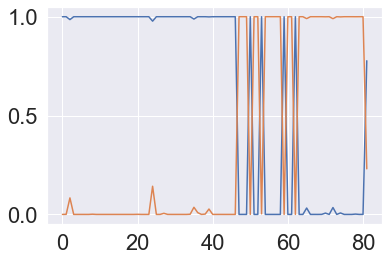

In [57]:
plt.plot(y_predict)

In [58]:
y_predict_1D = y_predict[:,1]

In [59]:
fpr , tpr , thresholds = roc_curve(y_test , y_predict_1D)
auc_rf = auc(fpr, tpr)

In [60]:
auc_rf

0.9373860182370821

In [61]:
x = y = np.arange(0,1.1,0.1)

In [62]:
x

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

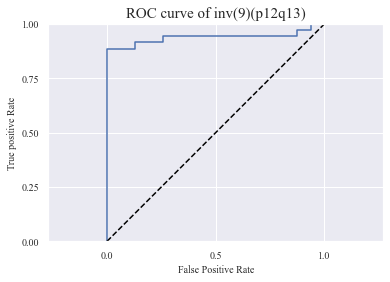

In [63]:
plt.plot(fpr, tpr)
plt.plot(x, y, '--', color='black')
plt.title('ROC curve of inv(9)(p12q13)', fontsize=15, fontname = 'Times New Roman')
plt.xlabel('False Positive Rate', fontsize=10, fontname = 'Times New Roman')
plt.ylabel('True positive Rate', fontsize=10, fontname = 'Times New Roman')
plt.axis('equal')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(fontsize=10, fontname = 'Times New Roman')
plt.yticks(fontsize=10, fontname = 'Times New Roman')

plt.savefig('ROC_Curve_Chr_09_' + str(iterationNumber) + '.png', dpi=400)
plt.show()

#### 3.10.4.1 AUC Value

In [64]:
auc_value = auc(fpr, tpr)
auc_value_dict[iterationNumber] = auc_value

In [65]:
print('AUC is ', auc_value)

AUC is  0.9373860182370821


In [66]:
iterationNumber = iterationNumber + 1

# 3. Iteration 1

## 3.1 Image Input

### 3.1.x Display the Split Method

In [67]:
print('Iteration No. ', iterationNumber)


for chrNo in theWhole.keys():
    print(chrNo)
    print('   Train: ')
    for item in X_train_name[chrNo][iterationNumber]:
        print('       ', item.split('\\')[-1])
    print('   Test: ')
    for item in X_test_name[chrNo][iterationNumber]:
        print('       ', item.split('\\')[-1])

Iteration No.  1
chr_09
   Train: 
        182433_9p12q-11L.bmp
        182433_9p12q-12L.bmp
        182433_9p12q-13L.bmp
        182433_9p12q-14L.bmp
        182433_9p12q-15L.bmp
        182433_9p12q-17L.bmp
        182433_9p12q-18L.bmp
        182433_9p12q-19L.bmp
        182433_9p12q-20L.bmp
        182433_9p12q-21L.bmp
        182433_9p12q-22L.bmp
        182433_9p12q-2L.bmp
        182433_9p12q-4L.bmp
        182433_9p12q-6L.bmp
        182433_9p12q-7L.bmp
        182433_9p12q-8L.bmp
        182433_9p12q-9L.bmp
        184431-_9p12q13_10L.bmp
        184431-_9p12q13_11L.bmp
        184431-_9p12q13_12L.bmp
        184431-_9p12q13_13L.bmp
        184431-_9p12q13_14L.bmp
        184431-_9p12q13_15L.bmp
        184431-_9p12q13_17L.bmp
        184431-_9p12q13_18L.bmp
        184431-_9p12q13_19L.bmp
        184431-_9p12q13_1L.bmp
        184431-_9p12q13_20L.bmp
        184431-_9p12q13_21L.bmp
        184431-_9p12q13_22L.bmp
        184431-_9p12q13_23L.bmp
        184431-_9p12q13_24L.bmp

### 3.1.2. Assignment of Training Data

#### 3.1.2.1 Training: Image Object Assignment

In [68]:
image = {}

# 定义容纳图片对象的dictionary类型的变量image

i = 0

for chrNo in theWhole.keys():
    image[chrNo] = []
    for case in X_train_name[chrNo][iterationNumber]:
        
        # 上面一行第二个中括号内为split的序号，0为第0次split分法
        
        img = Image.open(case)
        image[chrNo].append(img)
        
        # image字典接受的是图片对象

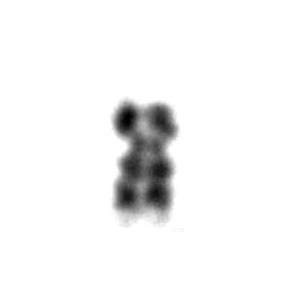

In [69]:
image['chr_09'][1] # 测试一下图像对象

#### 3.1.2.2. Training: Data Extraction from Images

#### - Training Set Data: 将图像对象转变为矩阵数值

In [70]:
data = {}
#rgb_data = {}

for chrNo in image.keys():
    data[chrNo] = []; 
    #rgb_data[chrNo] = []
    for case in image[chrNo]:
        grey, rgb = extractData(case)
        data[chrNo].append(grey)
        #rgb_data[chrNo].append(rgb)

In [71]:
array = {}

for chrNo in data.keys():
    array[chrNo] = []
    for case in data[chrNo]:            
        array[chrNo].append(case)

x_train_list = []
y_train_list = []

for y, x in array.items():    
    for x_item in x:
        x_train_list.append(x_item)
        y_train_list.append(y)
        
        # 将图像数据赋值给x_train_list;
        # 将标签数据赋值给y_train_list.

### 3.1.3. Assignment of Testing Data

#### 3.1.3.1. Testing: Image Object Assignment

In [72]:
# 方法同前面的Training Set

image = {}
i = 0

for chrNo in theWhole.keys():
    image[chrNo] = []
    for case in X_test_name[chrNo][iterationNumber]: # Change here for different iterations!!!!!
        
        # 上面一行第二个中括号内为split的序号，0为第0次split分法
        
        img = Image.open(case)
        image[chrNo].append(img)

#### 3.1.3.2. Testing: Data Extraction from Images

In [73]:
data = {}
#rgb_data = {}

for chrNo in image.keys():
    data[chrNo] = []; 
    #rgb_data[chrNo] = []
    for case in image[chrNo]:
        grey, rgb = extractData(case)
        data[chrNo].append(grey)
        #rgb_data[chrNo].append(rgb)

In [74]:
array = {}

for chrNo in data.keys():
    array[chrNo] = []
    for case in data[chrNo]:            
        array[chrNo].append(case)

x_test_list = []
y_test_list = []

for y, x in array.items():    
    for x_item in x:
        x_test_list.append(x_item)
        y_test_list.append(y)

### 3.1.4. ChromConvert

In [75]:
# 将染色体序号和异常核型名称更换为序号，序号定义在程序开始部分

y_train_digital_list = []
for item in y_train_list:
    y_train_digital_list.append(chromConvert[item])
    
y_test_digital_list = []
for item in y_test_list:
    y_test_digital_list.append(chromConvert[item])

### 3.1.5. Change to Numpy Array

In [76]:
X_train = np.array(x_train_list)
y_train = np.array(y_train_digital_list)

In [77]:
X_test = np.array(x_test_list)
y_test = np.array(y_test_digital_list)

In [78]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [79]:
len(X_train)

488

In [80]:
X_train[0].shape

(300, 300)

## 3.2. Convolutional Neural Network

### 3.2.1 Data Preparation

In [81]:
X_train = X_train.reshape(-1, 300, 300, 1)
X_test = X_test.reshape(-1, 300, 300, 1)

### 3.2.3 Training Model Design

In [82]:
model = Sequential()

In [83]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

In [84]:
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(600, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

### 3.2.4. Tensorboard Initilization

In [85]:
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### 3.2.5. Compile the modal

In [86]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### 3.2.6. Fitting (拟合)

In [87]:
model.fit(X_train, y_train, epochs=80, batch_size=64, verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback])

Epoch 1/80
8/8 [==============================] - 2s 229ms/step - loss: 68.5303 - accuracy: 0.5061 - val_loss: 0.6913 - val_accuracy: 0.5732
Epoch 2/80
8/8 [==============================] - 1s 125ms/step - loss: 0.8227 - accuracy: 0.5922 - val_loss: 0.6437 - val_accuracy: 0.8293
Epoch 3/80
8/8 [==============================] - 1s 120ms/step - loss: 0.8050 - accuracy: 0.6742 - val_loss: 0.6437 - val_accuracy: 0.5732
Epoch 4/80
8/8 [==============================] - 1s 122ms/step - loss: 0.6764 - accuracy: 0.7316 - val_loss: 0.4202 - val_accuracy: 0.8293
Epoch 5/80
8/8 [==============================] - 1s 124ms/step - loss: 1.3158 - accuracy: 0.5717 - val_loss: 0.5627 - val_accuracy: 0.5732
Epoch 6/80
8/8 [==============================] - 1s 120ms/step - loss: 0.5342 - accuracy: 0.6086 - val_loss: 0.4214 - val_accuracy: 0.8171
Epoch 7/80
8/8 [==============================] - 1s 121ms/step - loss: 0.3052 - accuracy: 0.8873 - val_loss: 0.2729 - val_accuracy: 0.9024
Epoch 8/80
8/8 [===

8/8 [==============================] - 1s 121ms/step - loss: 6.3682e-07 - accuracy: 1.0000 - val_loss: 2.2202 - val_accuracy: 0.8902
Epoch 59/80
8/8 [==============================] - 1s 122ms/step - loss: 6.0018e-07 - accuracy: 1.0000 - val_loss: 2.2395 - val_accuracy: 0.8902
Epoch 60/80
8/8 [==============================] - 1s 122ms/step - loss: 5.5621e-07 - accuracy: 1.0000 - val_loss: 2.2542 - val_accuracy: 0.8902
Epoch 61/80
8/8 [==============================] - 1s 122ms/step - loss: 5.2470e-07 - accuracy: 1.0000 - val_loss: 2.2699 - val_accuracy: 0.8902
Epoch 62/80
8/8 [==============================] - 1s 121ms/step - loss: 4.9368e-07 - accuracy: 1.0000 - val_loss: 2.2825 - val_accuracy: 0.8902
Epoch 63/80
8/8 [==============================] - 1s 119ms/step - loss: 4.6388e-07 - accuracy: 1.0000 - val_loss: 2.2951 - val_accuracy: 0.8902
Epoch 64/80
8/8 [==============================] - 1s 122ms/step - loss: 4.3847e-07 - accuracy: 1.0000 - val_loss: 2.3101 - val_accuracy: 0.89

### 3.2.7 Summary

In [88]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 322624)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 300)              

### 3.2.8. Tensorboard Display

In [89]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 19276), started 11 days, 6:03:50 ago. (Use '!kill 19276' to kill it.)

## 3.8 Save the Model

In [90]:
model.save('saved_model/model_Chr_09_cnn_iteration_'+str(iterationNumber))

INFO:tensorflow:Assets written to: saved_model/model_Chr_09_cnn_iteration_1\assets


## 3.9 Load the Model

In [91]:
model_reload = keras.models.load_model('saved_model/model_Chr_09_cnn_iteration_'+str(iterationNumber))

## 3.10. Performance Measures

### 3.10.1. Accuracy

In [92]:
loss, acc = model_reload.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)
accuracies[iterationNumber] = acc

Test Accuracy: 0.890


In [93]:
len(X_test)

82

In [94]:
y_predict = model_reload.predict(X_test)

In [95]:
len(y_predict)

82

In [96]:
# The number 32 means the type number of all chromosome class number inlcuding abnormal ones
y_predict_filtered = []

for sample in y_predict:
    maximum = 0
    indicator = 0
    for i in range(2):
        if sample[i] > maximum:
            maximum = sample[i]
            indicator = i
    y_predict_filtered.append(indicator)        

In [97]:
label = ['chr_09', 'chr_9_inversion']

label_convert = []

for i in range(2):
    label_convert.append(chromConvert_reverse[i])

### 3.10.2. Classification Report

In [98]:
performanceReport[iterationNumber] = classification_report(y_test, y_predict_filtered, target_names=label_convert)

# Change here for different iteration!!!!!

print(performanceReport[iterationNumber])

                 precision    recall  f1-score   support

         chr_09       0.93      0.87      0.90        47
chr_9_inversion       0.84      0.91      0.88        35

      micro avg       0.89      0.89      0.89        82
      macro avg       0.89      0.89      0.89        82
   weighted avg       0.89      0.89      0.89        82



### 3.10.3. Confusion Matrix

In [99]:
cm = np.array(confusion_matrix(y_test, y_predict_filtered, labels=[0, 1]))
confusion = pd.DataFrame(cm, index=label_convert,
                        columns=label_convert)
confusion.to_csv('ConfusionMatrix_Chr_09_KaryoType_CNN' + str(iterationNumber) + '.csv')
confusion

,chr_09,chr_9_inversion
chr_09,41,6
chr_9_inversion,3,32


#### Heat Map

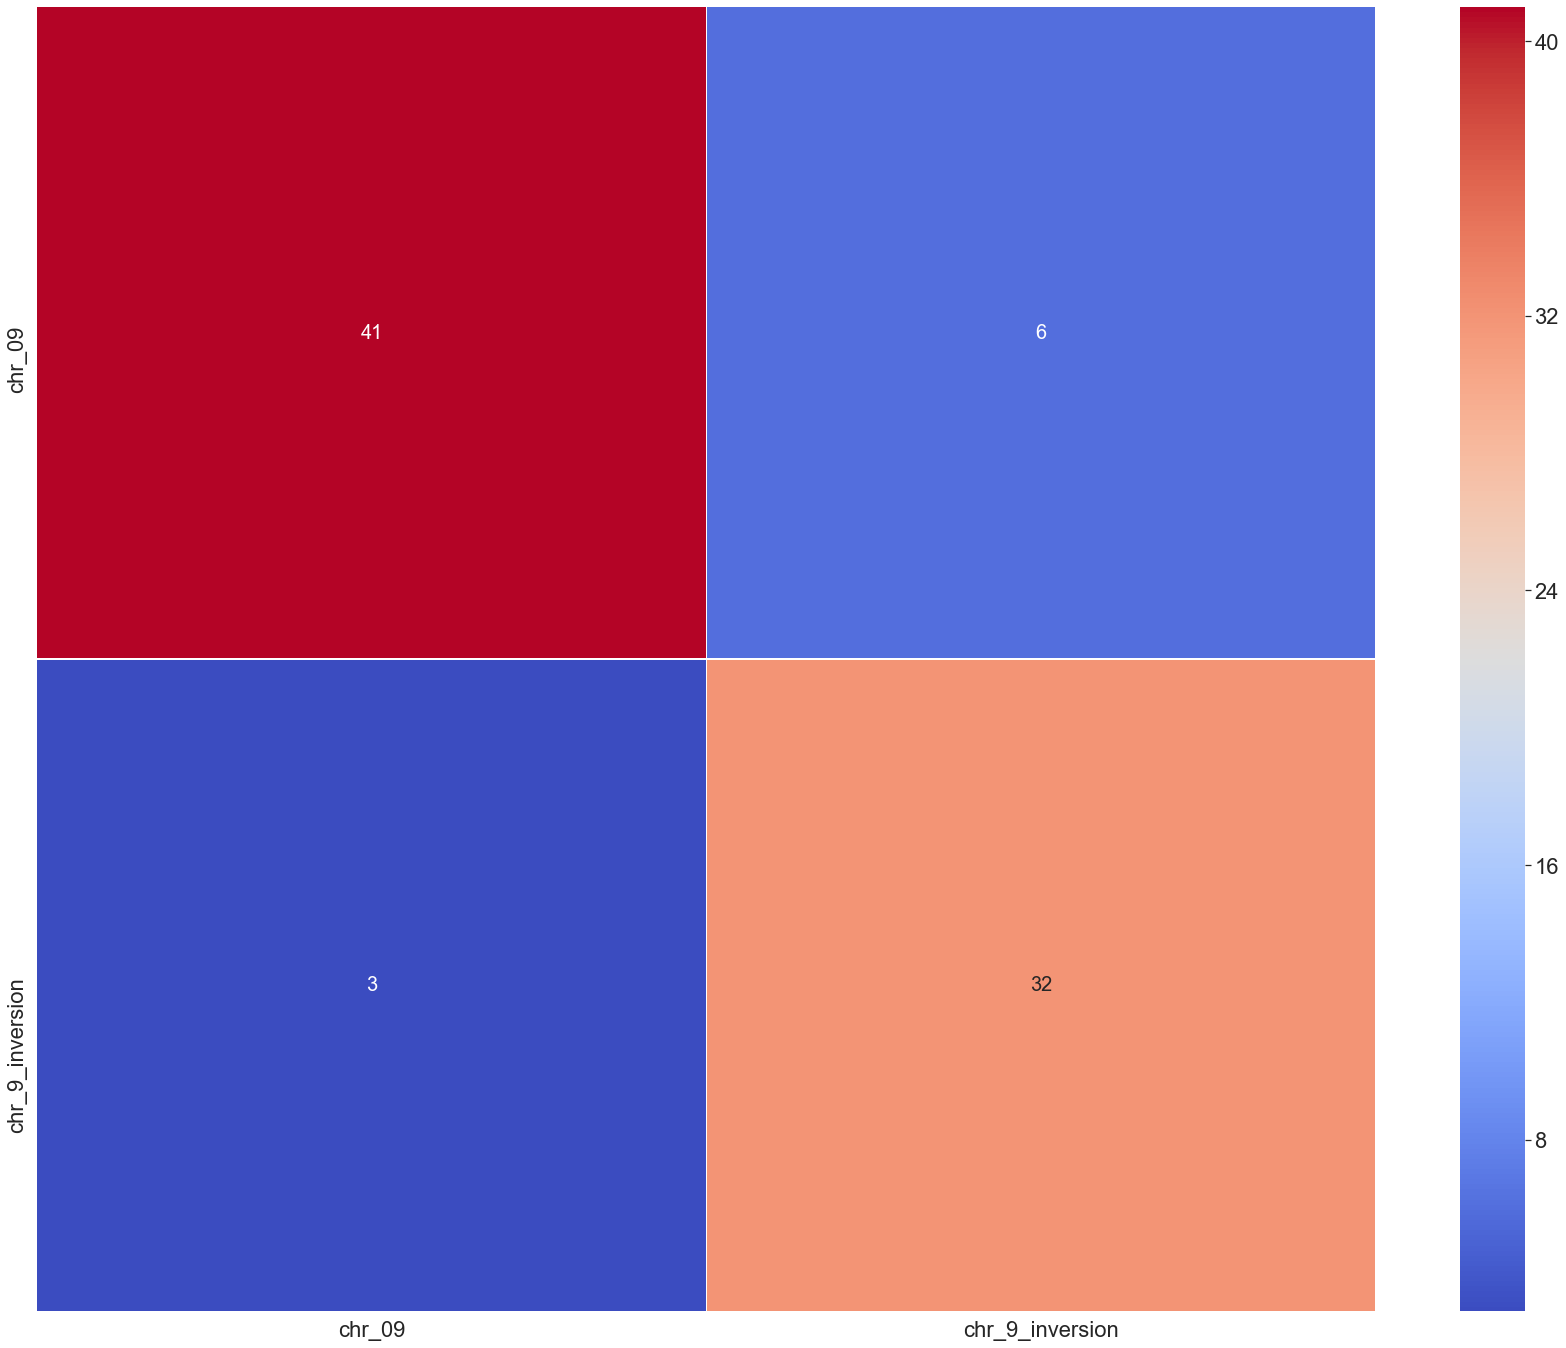

In [100]:
plt.figure(figsize=(30, 24))
heat_map = sb.heatmap(confusion, annot=True,  # It's a Seaborn function
                      cmap='coolwarm', 
                      xticklabels=confusion.columns, yticklabels=confusion.index, 
                      linewidths=.5, 
                      annot_kws={"size": 20})
sb.set(font_scale = 2)

In [101]:
fig = heat_map.get_figure()    
fig.savefig('Heatmap_Chr_09_Iteration_' + str(iterationNumber) + '.png', dpi=400)

### 3.10.4. ROC

In [102]:
y_predict

array([[7.25548947e-04, 1.99887201e-01],
       [1.00000000e+00, 1.00052994e-16],
       [9.99950051e-01, 6.58197052e-08],
       [9.99999166e-01, 1.25469343e-10],
       [9.99223948e-01, 2.86763793e-07],
       [1.00000000e+00, 4.52767158e-23],
       [6.17563387e-08, 2.21531726e-02],
       [1.00000000e+00, 1.33530862e-21],
       [1.00000000e+00, 3.36448653e-31],
       [1.00000000e+00, 4.10771981e-12],
       [1.00000000e+00, 1.73822739e-19],
       [1.00000000e+00, 3.52689548e-15],
       [1.00000000e+00, 3.27502077e-13],
       [2.22702831e-04, 2.07973719e-01],
       [9.99990344e-01, 8.68011529e-09],
       [9.96141851e-01, 2.59472313e-06],
       [6.70395247e-25, 3.23876477e-04],
       [1.00000000e+00, 1.01350156e-25],
       [1.00000000e+00, 1.37354795e-13],
       [3.15380521e-14, 1.15307579e-02],
       [1.00000000e+00, 2.13752833e-32],
       [9.99993682e-01, 8.21406232e-09],
       [1.00000000e+00, 4.75364987e-14],
       [1.94746517e-05, 1.79056457e-11],
       [9.230807

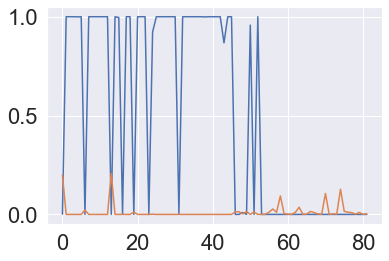

In [103]:
plt.plot(y_predict)

In [104]:
y_predict_1D = y_predict[:,1]

In [105]:
fpr , tpr , thresholds = roc_curve(y_test , y_predict_1D)
auc_rf = auc(fpr, tpr)

In [106]:
auc_rf

0.8759878419452888

In [107]:
x = y = np.arange(0,1.1,0.1)

In [108]:
x

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

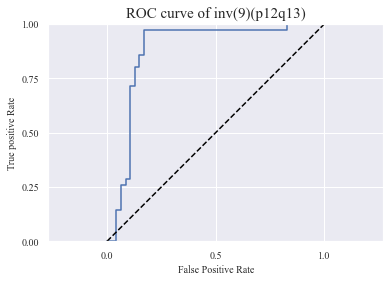

In [109]:
plt.plot(fpr, tpr)
plt.plot(x, y, '--', color='black')
plt.title('ROC curve of inv(9)(p12q13)', fontsize=15, fontname = 'Times New Roman')
plt.xlabel('False Positive Rate', fontsize=10, fontname = 'Times New Roman')
plt.ylabel('True positive Rate', fontsize=10, fontname = 'Times New Roman')
plt.axis('equal')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(fontsize=10, fontname = 'Times New Roman')
plt.yticks(fontsize=10, fontname = 'Times New Roman')

plt.savefig('ROC_Curve_Chr_09_' + str(iterationNumber) + '.png', dpi=400)
plt.show()

#### 3.10.4.1 AUC Value

In [110]:
auc_value = auc(fpr, tpr)
auc_value_dict[iterationNumber] = auc_value

In [111]:
print('AUC is ', auc_value)

AUC is  0.8759878419452888


In [112]:
iterationNumber = iterationNumber + 1

# 3. Iteration 2

## 3.1 Image Input

### 3.1.x Display the Split Method

In [113]:
print('Iteration No. ', iterationNumber)


for chrNo in theWhole.keys():
    print(chrNo)
    print('   Train: ')
    for item in X_train_name[chrNo][iterationNumber]:
        print('       ', item.split('\\')[-1])
    print('   Test: ')
    for item in X_test_name[chrNo][iterationNumber]:
        print('       ', item.split('\\')[-1])

Iteration No.  2
chr_09
   Train: 
        182433_9p12q-10L.bmp
        182433_9p12q-11L.bmp
        182433_9p12q-12L.bmp
        182433_9p12q-13L.bmp
        182433_9p12q-14L.bmp
        182433_9p12q-17L.bmp
        182433_9p12q-18L.bmp
        182433_9p12q-1L.bmp
        182433_9p12q-20L.bmp
        182433_9p12q-21L.bmp
        182433_9p12q-22L.bmp
        182433_9p12q-2L.bmp
        182433_9p12q-3L.bmp
        182433_9p12q-4L.bmp
        182433_9p12q-5L.bmp
        182433_9p12q-7L.bmp
        182433_9p12q-9L.bmp
        184431-_9p12q13_10L.bmp
        184431-_9p12q13_11L.bmp
        184431-_9p12q13_12L.bmp
        184431-_9p12q13_13L.bmp
        184431-_9p12q13_14L.bmp
        184431-_9p12q13_15L.bmp
        184431-_9p12q13_17L.bmp
        184431-_9p12q13_18L.bmp
        184431-_9p12q13_19L.bmp
        184431-_9p12q13_1L.bmp
        184431-_9p12q13_20L.bmp
        184431-_9p12q13_21L.bmp
        184431-_9p12q13_22L.bmp
        184431-_9p12q13_24L.bmp
        184431-_9p12q13_26L.bmp


### 3.1.2. Assignment of Training Data

#### 3.1.2.1 Training: Image Object Assignment

In [114]:
image = {}

# 定义容纳图片对象的dictionary类型的变量image

i = 0

for chrNo in theWhole.keys():
    image[chrNo] = []
    for case in X_train_name[chrNo][iterationNumber]:
        
        # 上面一行第二个中括号内为split的序号，0为第0次split分法
        
        img = Image.open(case)
        image[chrNo].append(img)
        
        # image字典接受的是图片对象

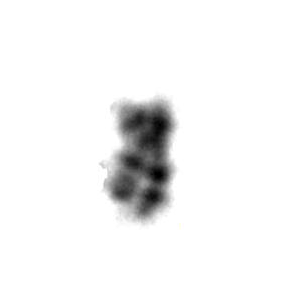

In [115]:
image['chr_09'][1] # 测试一下图像对象

#### 3.1.2.2. Training: Data Extraction from Images

#### - Training Set Data: 将图像对象转变为矩阵数值

In [116]:
data = {}
#rgb_data = {}

for chrNo in image.keys():
    data[chrNo] = []; 
    #rgb_data[chrNo] = []
    for case in image[chrNo]:
        grey, rgb = extractData(case)
        data[chrNo].append(grey)
        #rgb_data[chrNo].append(rgb)

In [117]:
array = {}

for chrNo in data.keys():
    array[chrNo] = []
    for case in data[chrNo]:            
        array[chrNo].append(case)

x_train_list = []
y_train_list = []

for y, x in array.items():    
    for x_item in x:
        x_train_list.append(x_item)
        y_train_list.append(y)
        
        # 将图像数据赋值给x_train_list;
        # 将标签数据赋值给y_train_list.

### 3.1.3. Assignment of Testing Data

#### 3.1.3.1. Testing: Image Object Assignment

In [118]:
# 方法同前面的Training Set

image = {}
i = 0

for chrNo in theWhole.keys():
    image[chrNo] = []
    for case in X_test_name[chrNo][iterationNumber]: # Change here for different iterations!!!!!
        
        # 上面一行第二个中括号内为split的序号，0为第0次split分法
        
        img = Image.open(case)
        image[chrNo].append(img)

#### 3.1.3.2. Testing: Data Extraction from Images

In [119]:
data = {}
#rgb_data = {}

for chrNo in image.keys():
    data[chrNo] = []; 
    #rgb_data[chrNo] = []
    for case in image[chrNo]:
        grey, rgb = extractData(case)
        data[chrNo].append(grey)
        #rgb_data[chrNo].append(rgb)

In [120]:
array = {}

for chrNo in data.keys():
    array[chrNo] = []
    for case in data[chrNo]:            
        array[chrNo].append(case)

x_test_list = []
y_test_list = []

for y, x in array.items():    
    for x_item in x:
        x_test_list.append(x_item)
        y_test_list.append(y)

### 3.1.4. ChromConvert

In [121]:
# 将染色体序号和异常核型名称更换为序号，序号定义在程序开始部分

y_train_digital_list = []
for item in y_train_list:
    y_train_digital_list.append(chromConvert[item])
    
y_test_digital_list = []
for item in y_test_list:
    y_test_digital_list.append(chromConvert[item])

### 3.1.5. Change to Numpy Array

In [122]:
X_train = np.array(x_train_list)
y_train = np.array(y_train_digital_list)

In [123]:
X_test = np.array(x_test_list)
y_test = np.array(y_test_digital_list)

In [124]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [125]:
len(X_train)

488

In [126]:
X_train[0].shape

(300, 300)

## 3.2. Convolutional Neural Network

### 3.2.1 Data Preparation

In [127]:
X_train = X_train.reshape(-1, 300, 300, 1)
X_test = X_test.reshape(-1, 300, 300, 1)

### 3.2.3 Training Model Design

In [128]:
model = Sequential()

In [129]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

In [130]:
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(600, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

### 3.2.4. Tensorboard Initilization

In [131]:
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### 3.2.5. Compile the modal

In [132]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### 3.2.6. Fitting (拟合)

In [133]:
model.fit(X_train, y_train, epochs=80, batch_size=64, verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback])

Epoch 1/80
8/8 [==============================] - 2s 245ms/step - loss: 48.5258 - accuracy: 0.5123 - val_loss: 0.6911 - val_accuracy: 0.7805
Epoch 2/80
8/8 [==============================] - 1s 135ms/step - loss: 0.7143 - accuracy: 0.5881 - val_loss: 0.6822 - val_accuracy: 0.5732
Epoch 3/80
8/8 [==============================] - 1s 131ms/step - loss: 0.7356 - accuracy: 0.4857 - val_loss: 0.6791 - val_accuracy: 0.7683
Epoch 4/80
8/8 [==============================] - 1s 130ms/step - loss: 1.6748 - accuracy: 0.6885 - val_loss: 0.6847 - val_accuracy: 0.5854
Epoch 5/80
8/8 [==============================] - 1s 130ms/step - loss: 0.6656 - accuracy: 0.6352 - val_loss: 0.5767 - val_accuracy: 0.8049
Epoch 6/80
8/8 [==============================] - 1s 131ms/step - loss: 0.4654 - accuracy: 0.8176 - val_loss: 0.2195 - val_accuracy: 0.9390
Epoch 7/80
8/8 [==============================] - 1s 126ms/step - loss: 0.2674 - accuracy: 0.8955 - val_loss: 0.2011 - val_accuracy: 0.9390
Epoch 8/80
8/8 [===

Epoch 59/80
8/8 [==============================] - 1s 129ms/step - loss: 4.3726e-07 - accuracy: 1.0000 - val_loss: 3.2322 - val_accuracy: 0.8049
Epoch 60/80
8/8 [==============================] - 1s 131ms/step - loss: 4.2309e-07 - accuracy: 1.0000 - val_loss: 3.2417 - val_accuracy: 0.8049
Epoch 61/80
8/8 [==============================] - 1s 131ms/step - loss: 4.0745e-07 - accuracy: 1.0000 - val_loss: 3.2504 - val_accuracy: 0.8049
Epoch 62/80
8/8 [==============================] - 1s 132ms/step - loss: 3.9280e-07 - accuracy: 1.0000 - val_loss: 3.2604 - val_accuracy: 0.8049
Epoch 63/80
8/8 [==============================] - 1s 131ms/step - loss: 3.7643e-07 - accuracy: 1.0000 - val_loss: 3.2701 - val_accuracy: 0.8049
Epoch 64/80
8/8 [==============================] - 1s 128ms/step - loss: 3.5982e-07 - accuracy: 1.0000 - val_loss: 3.2808 - val_accuracy: 0.8049
Epoch 65/80
8/8 [==============================] - 1s 132ms/step - loss: 3.4492e-07 - accuracy: 1.0000 - val_loss: 3.2929 - val_ac

### 3.2.7 Summary

In [134]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 322624)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 300)              

### 3.2.8. Tensorboard Display

In [135]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 19276), started 11 days, 6:13:20 ago. (Use '!kill 19276' to kill it.)

## 3.8 Save the Model

In [136]:
model.save('saved_model/model_Chr_09_cnn_iteration_'+str(iterationNumber))

INFO:tensorflow:Assets written to: saved_model/model_Chr_09_cnn_iteration_2\assets


## 3.9 Load the Model

In [137]:
model_reload = keras.models.load_model('saved_model/model_Chr_09_cnn_iteration_'+str(iterationNumber))

## 3.10. Performance Measures

### 3.10.1. Accuracy

In [138]:
loss, acc = model_reload.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)
accuracies[iterationNumber] = acc

Test Accuracy: 0.805


In [139]:
len(X_test)

82

In [140]:
y_predict = model_reload.predict(X_test)

In [141]:
len(y_predict)

82

In [142]:
# The number 32 means the type number of all chromosome class number inlcuding abnormal ones
y_predict_filtered = []

for sample in y_predict:
    maximum = 0
    indicator = 0
    for i in range(2):
        if sample[i] > maximum:
            maximum = sample[i]
            indicator = i
    y_predict_filtered.append(indicator)        

In [143]:
label = ['chr_09', 'chr_9_inversion']

label_convert = []

for i in range(2):
    label_convert.append(chromConvert_reverse[i])

### 3.10.2. Classification Report

In [144]:
performanceReport[iterationNumber] = classification_report(y_test, y_predict_filtered, target_names=label_convert)

# Change here for different iteration!!!!!

print(performanceReport[iterationNumber])

                 precision    recall  f1-score   support

         chr_09       0.78      0.91      0.84        47
chr_9_inversion       0.85      0.66      0.74        35

      micro avg       0.80      0.80      0.80        82
      macro avg       0.82      0.79      0.79        82
   weighted avg       0.81      0.80      0.80        82



### 3.10.3. Confusion Matrix

In [145]:
cm = np.array(confusion_matrix(y_test, y_predict_filtered, labels=[0, 1]))
confusion = pd.DataFrame(cm, index=label_convert,
                        columns=label_convert)
confusion.to_csv('ConfusionMatrix_Chr_09_KaryoType_CNN' + str(iterationNumber) + '.csv')
confusion

,chr_09,chr_9_inversion
chr_09,43,4
chr_9_inversion,12,23


#### Heat Map

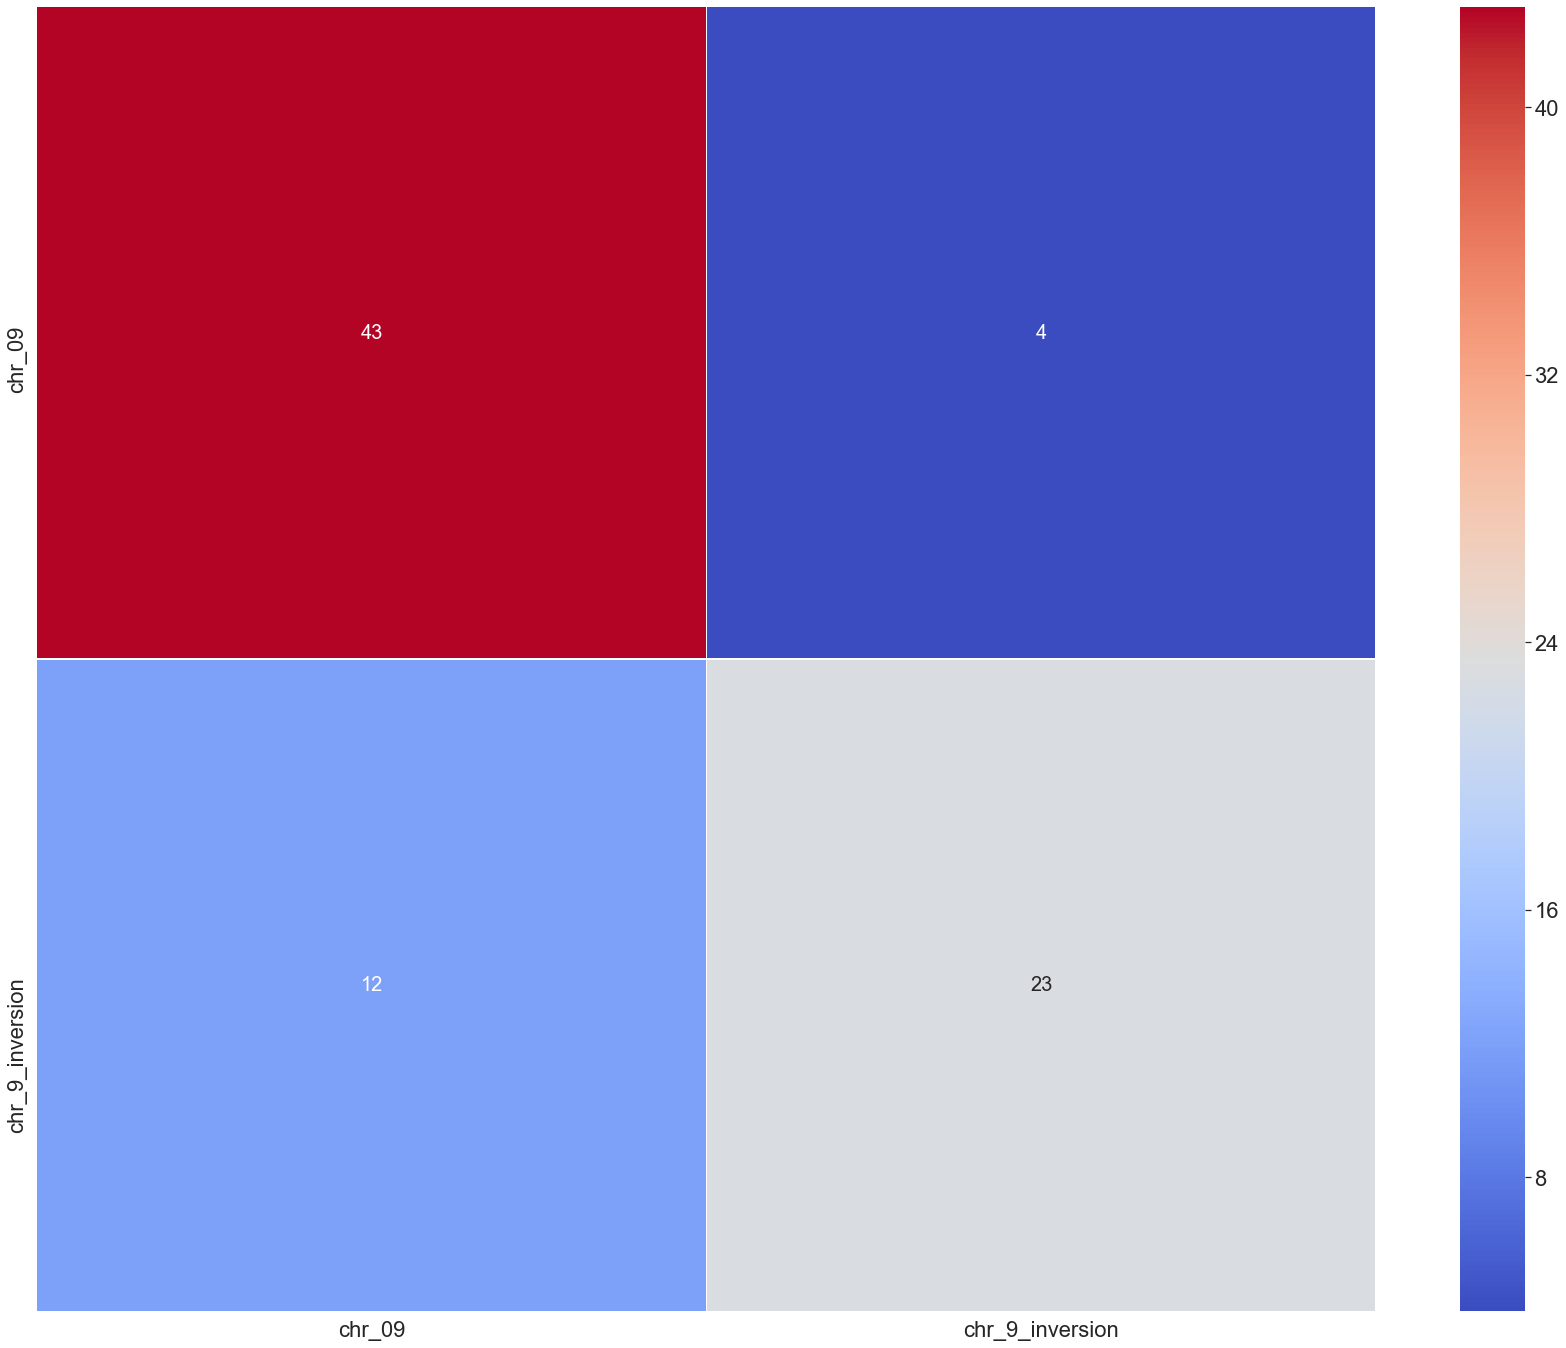

In [146]:
plt.figure(figsize=(30, 24))
heat_map = sb.heatmap(confusion, annot=True,  # It's a Seaborn function
                      cmap='coolwarm', 
                      xticklabels=confusion.columns, yticklabels=confusion.index, 
                      linewidths=.5, 
                      annot_kws={"size": 20})
sb.set(font_scale = 2)

In [147]:
fig = heat_map.get_figure()    
fig.savefig('Heatmap_Chr_09_Iteration_' + str(iterationNumber) + '.png', dpi=400)

### 3.10.4. ROC

In [148]:
y_predict

array([[9.4112450e-01, 4.9259752e-04],
       [9.9999475e-01, 5.8500817e-13],
       [1.5842480e-11, 2.6870947e-04],
       [1.0000000e+00, 6.0475213e-22],
       [9.9804127e-01, 9.8942863e-08],
       [9.9743831e-01, 6.5604252e-07],
       [9.9957937e-01, 1.7864297e-08],
       [9.9975461e-01, 4.2332395e-09],
       [7.9901892e-01, 4.5433975e-04],
       [9.9999809e-01, 7.2471929e-14],
       [9.9989772e-01, 2.0718934e-10],
       [9.9999404e-01, 7.2497683e-13],
       [9.9997735e-01, 4.2280125e-12],
       [9.9974781e-01, 4.4318788e-10],
       [9.9884653e-01, 8.6903398e-08],
       [9.9545223e-01, 6.7448800e-06],
       [9.9733007e-01, 1.1342032e-06],
       [9.9948716e-01, 3.4269412e-08],
       [9.8500985e-01, 5.2330062e-05],
       [9.7106129e-01, 3.2650767e-04],
       [9.9987137e-01, 1.4814365e-09],
       [9.9856514e-01, 3.1143594e-07],
       [9.9977702e-01, 4.3070365e-09],
       [9.9990356e-01, 6.1894373e-10],
       [9.5298481e-01, 4.5647862e-04],
       [9.9230361e-01, 8.

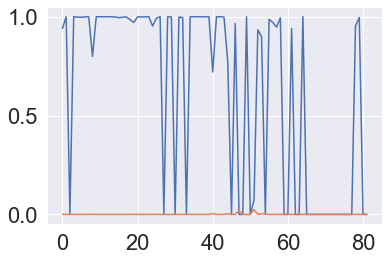

In [149]:
plt.plot(y_predict)

In [150]:
y_predict_1D = y_predict[:,1]

In [151]:
fpr , tpr , thresholds = roc_curve(y_test , y_predict_1D)
auc_rf = auc(fpr, tpr)

In [152]:
auc_rf

0.5799392097264437

In [153]:
x = y = np.arange(0,1.1,0.1)

In [154]:
x

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

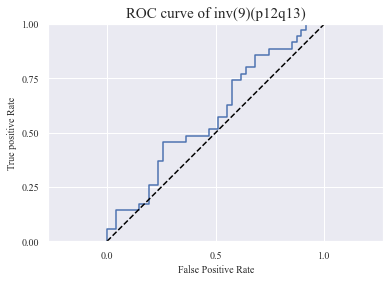

In [155]:
plt.plot(fpr, tpr)
plt.plot(x, y, '--', color='black')
plt.title('ROC curve of inv(9)(p12q13)', fontsize=15, fontname = 'Times New Roman')
plt.xlabel('False Positive Rate', fontsize=10, fontname = 'Times New Roman')
plt.ylabel('True positive Rate', fontsize=10, fontname = 'Times New Roman')
plt.axis('equal')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(fontsize=10, fontname = 'Times New Roman')
plt.yticks(fontsize=10, fontname = 'Times New Roman')

plt.savefig('ROC_Curve_Chr_09_' + str(iterationNumber) + '.png', dpi=400)
plt.show()

#### 3.10.4.1 AUC Value

In [156]:
auc_value = auc(fpr, tpr)
auc_value_dict[iterationNumber] = auc_value

In [157]:
print('AUC is ', auc_value)

AUC is  0.5799392097264437


In [158]:
iterationNumber = iterationNumber + 1

# 3. Iteration 3

## 3.1 Image Input

### 3.1.x Display the Split Method

In [159]:
print('Iteration No. ', iterationNumber)


for chrNo in theWhole.keys():
    print(chrNo)
    print('   Train: ')
    for item in X_train_name[chrNo][iterationNumber]:
        print('       ', item.split('\\')[-1])
    print('   Test: ')
    for item in X_test_name[chrNo][iterationNumber]:
        print('       ', item.split('\\')[-1])

Iteration No.  3
chr_09
   Train: 
        182433_9p12q-10L.bmp
        182433_9p12q-11L.bmp
        182433_9p12q-12L.bmp
        182433_9p12q-13L.bmp
        182433_9p12q-14L.bmp
        182433_9p12q-15L.bmp
        182433_9p12q-17L.bmp
        182433_9p12q-18L.bmp
        182433_9p12q-19L.bmp
        182433_9p12q-1L.bmp
        182433_9p12q-20L.bmp
        182433_9p12q-21L.bmp
        182433_9p12q-22L.bmp
        182433_9p12q-2L.bmp
        182433_9p12q-3L.bmp
        182433_9p12q-4L.bmp
        182433_9p12q-5L.bmp
        182433_9p12q-6L.bmp
        182433_9p12q-7L.bmp
        182433_9p12q-8L.bmp
        182433_9p12q-9L.bmp
        184431-_9p12q13_11L.bmp
        184431-_9p12q13_12L.bmp
        184431-_9p12q13_14L.bmp
        184431-_9p12q13_15L.bmp
        184431-_9p12q13_17L.bmp
        184431-_9p12q13_19L.bmp
        184431-_9p12q13_1L.bmp
        184431-_9p12q13_23L.bmp
        184431-_9p12q13_26L.bmp
        184431-_9p12q13_2L.bmp
        184431-_9p12q13_3L.bmp
        184431-_

### 3.1.2. Assignment of Training Data

#### 3.1.2.1 Training: Image Object Assignment

In [160]:
image = {}

# 定义容纳图片对象的dictionary类型的变量image

i = 0

for chrNo in theWhole.keys():
    image[chrNo] = []
    for case in X_train_name[chrNo][iterationNumber]:
        
        # 上面一行第二个中括号内为split的序号，0为第0次split分法
        
        img = Image.open(case)
        image[chrNo].append(img)
        
        # image字典接受的是图片对象

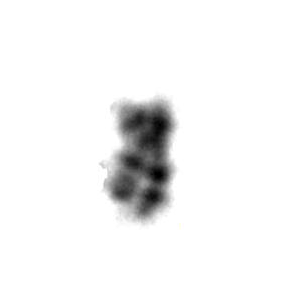

In [161]:
image['chr_09'][1] # 测试一下图像对象

#### 3.1.2.2. Training: Data Extraction from Images

#### - Training Set Data: 将图像对象转变为矩阵数值

In [162]:
data = {}
#rgb_data = {}

for chrNo in image.keys():
    data[chrNo] = []; 
    #rgb_data[chrNo] = []
    for case in image[chrNo]:
        grey, rgb = extractData(case)
        data[chrNo].append(grey)
        #rgb_data[chrNo].append(rgb)

In [163]:
array = {}

for chrNo in data.keys():
    array[chrNo] = []
    for case in data[chrNo]:            
        array[chrNo].append(case)

x_train_list = []
y_train_list = []

for y, x in array.items():    
    for x_item in x:
        x_train_list.append(x_item)
        y_train_list.append(y)
        
        # 将图像数据赋值给x_train_list;
        # 将标签数据赋值给y_train_list.

### 3.1.3. Assignment of Testing Data

#### 3.1.3.1. Testing: Image Object Assignment

In [164]:
# 方法同前面的Training Set

image = {}
i = 0

for chrNo in theWhole.keys():
    image[chrNo] = []
    for case in X_test_name[chrNo][iterationNumber]: # Change here for different iterations!!!!!
        
        # 上面一行第二个中括号内为split的序号，0为第0次split分法
        
        img = Image.open(case)
        image[chrNo].append(img)

#### 3.1.3.2. Testing: Data Extraction from Images

In [165]:
data = {}
#rgb_data = {}

for chrNo in image.keys():
    data[chrNo] = []; 
    #rgb_data[chrNo] = []
    for case in image[chrNo]:
        grey, rgb = extractData(case)
        data[chrNo].append(grey)
        #rgb_data[chrNo].append(rgb)

In [166]:
array = {}

for chrNo in data.keys():
    array[chrNo] = []
    for case in data[chrNo]:            
        array[chrNo].append(case)

x_test_list = []
y_test_list = []

for y, x in array.items():    
    for x_item in x:
        x_test_list.append(x_item)
        y_test_list.append(y)

### 3.1.4. ChromConvert

In [167]:
# 将染色体序号和异常核型名称更换为序号，序号定义在程序开始部分

y_train_digital_list = []
for item in y_train_list:
    y_train_digital_list.append(chromConvert[item])
    
y_test_digital_list = []
for item in y_test_list:
    y_test_digital_list.append(chromConvert[item])

### 3.1.5. Change to Numpy Array

In [168]:
X_train = np.array(x_train_list)
y_train = np.array(y_train_digital_list)

In [169]:
X_test = np.array(x_test_list)
y_test = np.array(y_test_digital_list)

In [170]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [171]:
len(X_train)

489

In [172]:
X_train[0].shape

(300, 300)

## 3.2. Convolutional Neural Network

### 3.2.1 Data Preparation

In [173]:
X_train = X_train.reshape(-1, 300, 300, 1)
X_test = X_test.reshape(-1, 300, 300, 1)

### 3.2.3 Training Model Design

In [174]:
model = Sequential()

In [175]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

In [176]:
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(600, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

### 3.2.4. Tensorboard Initilization

In [177]:
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### 3.2.5. Compile the modal

In [178]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### 3.2.6. Fitting (拟合)

In [179]:
model.fit(X_train, y_train, epochs=80, batch_size=64, verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback])

Epoch 1/80


ResourceExhaustedError:  OOM when allocating tensor with shape[64,64,147,147] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_3/conv2d_10/Relu (defined at <ipython-input-179-9bdbbae916c4>:3) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_98161]

Function call stack:
train_function


### 3.2.7 Summary

In [ ]:
model.summary()

### 3.2.8. Tensorboard Display

In [ ]:
%tensorboard --logdir logs/fit

## 3.8 Save the Model

In [ ]:
model.save('saved_model/model_Chr_09_cnn_iteration_'+str(iterationNumber))

## 3.9 Load the Model

In [ ]:
model_reload = keras.models.load_model('saved_model/model_Chr_09_cnn_iteration_'+str(iterationNumber))

## 3.10. Performance Measures

### 3.10.1. Accuracy

In [ ]:
loss, acc = model_reload.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)
accuracies[iterationNumber] = acc

In [ ]:
len(X_test)

In [ ]:
y_predict = model_reload.predict(X_test)

In [ ]:
len(y_predict)

In [ ]:
# The number 32 means the type number of all chromosome class number inlcuding abnormal ones
y_predict_filtered = []

for sample in y_predict:
    maximum = 0
    indicator = 0
    for i in range(2):
        if sample[i] > maximum:
            maximum = sample[i]
            indicator = i
    y_predict_filtered.append(indicator)        

In [ ]:
label = ['chr_09', 'chr_9_inversion']

label_convert = []

for i in range(2):
    label_convert.append(chromConvert_reverse[i])

### 3.10.2. Classification Report

In [ ]:
performanceReport[iterationNumber] = classification_report(y_test, y_predict_filtered, target_names=label_convert)

# Change here for different iteration!!!!!

print(performanceReport[iterationNumber])

### 3.10.3. Confusion Matrix

In [ ]:
cm = np.array(confusion_matrix(y_test, y_predict_filtered, labels=[0, 1]))
confusion = pd.DataFrame(cm, index=label_convert,
                        columns=label_convert)
confusion.to_csv('ConfusionMatrix_Chr_09_KaryoType_CNN' + str(iterationNumber) + '.csv')
confusion

#### Heat Map

In [ ]:
plt.figure(figsize=(30, 24))
heat_map = sb.heatmap(confusion, annot=True,  # It's a Seaborn function
                      cmap='coolwarm', 
                      xticklabels=confusion.columns, yticklabels=confusion.index, 
                      linewidths=.5, 
                      annot_kws={"size": 20})
sb.set(font_scale = 2)

In [ ]:
fig = heat_map.get_figure()    
fig.savefig('Heatmap_Chr_09_Iteration_' + str(iterationNumber) + '.png', dpi=400)

### 3.10.4. ROC

In [ ]:
y_predict

In [ ]:
plt.plot(y_predict)

In [ ]:
y_predict_1D = y_predict[:,1]

In [ ]:
fpr , tpr , thresholds = roc_curve(y_test , y_predict_1D)
auc_rf = auc(fpr, tpr)

In [ ]:
auc_rf

In [ ]:
x = y = np.arange(0,1.1,0.1)

In [ ]:
x

In [ ]:
plt.plot(fpr, tpr)
plt.plot(x, y, '--', color='black')
plt.title('ROC curve of inv(9)(p12q13)', fontsize=15, fontname = 'Times New Roman')
plt.xlabel('False Positive Rate', fontsize=10, fontname = 'Times New Roman')
plt.ylabel('True positive Rate', fontsize=10, fontname = 'Times New Roman')
plt.axis('equal')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(fontsize=10, fontname = 'Times New Roman')
plt.yticks(fontsize=10, fontname = 'Times New Roman')

plt.savefig('ROC_Curve_Chr_09_' + str(iterationNumber) + '.png', dpi=400)
plt.show()

#### 3.10.4.1 AUC Value

In [ ]:
auc_value = auc(fpr, tpr)
auc_value_dict[iterationNumber] = auc_value

In [ ]:
print('AUC is ', auc_value)

In [ ]:
iterationNumber = iterationNumber + 1

# 3. Iteration 4

## 3.1 Image Input

### 3.1.x Display the Split Method

In [ ]:
print('Iteration No. ', iterationNumber)


for chrNo in theWhole.keys():
    print(chrNo)
    print('   Train: ')
    for item in X_train_name[chrNo][iterationNumber]:
        print('       ', item.split('\\')[-1])
    print('   Test: ')
    for item in X_test_name[chrNo][iterationNumber]:
        print('       ', item.split('\\')[-1])

### 3.1.2. Assignment of Training Data

#### 3.1.2.1 Training: Image Object Assignment

In [ ]:
image = {}

# 定义容纳图片对象的dictionary类型的变量image

i = 0

for chrNo in theWhole.keys():
    image[chrNo] = []
    for case in X_train_name[chrNo][iterationNumber]:
        
        # 上面一行第二个中括号内为split的序号，0为第0次split分法
        
        img = Image.open(case)
        image[chrNo].append(img)
        
        # image字典接受的是图片对象

In [ ]:
image['chr_09'][1] # 测试一下图像对象

#### 3.1.2.2. Training: Data Extraction from Images

#### - Training Set Data: 将图像对象转变为矩阵数值

In [ ]:
data = {}
#rgb_data = {}

for chrNo in image.keys():
    data[chrNo] = []; 
    #rgb_data[chrNo] = []
    for case in image[chrNo]:
        grey, rgb = extractData(case)
        data[chrNo].append(grey)
        #rgb_data[chrNo].append(rgb)

In [ ]:
array = {}

for chrNo in data.keys():
    array[chrNo] = []
    for case in data[chrNo]:            
        array[chrNo].append(case)

x_train_list = []
y_train_list = []

for y, x in array.items():    
    for x_item in x:
        x_train_list.append(x_item)
        y_train_list.append(y)
        
        # 将图像数据赋值给x_train_list;
        # 将标签数据赋值给y_train_list.

### 3.1.3. Assignment of Testing Data

#### 3.1.3.1. Testing: Image Object Assignment

In [ ]:
# 方法同前面的Training Set

image = {}
i = 0

for chrNo in theWhole.keys():
    image[chrNo] = []
    for case in X_test_name[chrNo][iterationNumber]: # Change here for different iterations!!!!!
        
        # 上面一行第二个中括号内为split的序号，0为第0次split分法
        
        img = Image.open(case)
        image[chrNo].append(img)

#### 3.1.3.2. Testing: Data Extraction from Images

In [ ]:
data = {}
#rgb_data = {}

for chrNo in image.keys():
    data[chrNo] = []; 
    #rgb_data[chrNo] = []
    for case in image[chrNo]:
        grey, rgb = extractData(case)
        data[chrNo].append(grey)
        #rgb_data[chrNo].append(rgb)

In [ ]:
array = {}

for chrNo in data.keys():
    array[chrNo] = []
    for case in data[chrNo]:            
        array[chrNo].append(case)

x_test_list = []
y_test_list = []

for y, x in array.items():    
    for x_item in x:
        x_test_list.append(x_item)
        y_test_list.append(y)

### 3.1.4. ChromConvert

In [ ]:
# 将染色体序号和异常核型名称更换为序号，序号定义在程序开始部分

y_train_digital_list = []
for item in y_train_list:
    y_train_digital_list.append(chromConvert[item])
    
y_test_digital_list = []
for item in y_test_list:
    y_test_digital_list.append(chromConvert[item])

### 3.1.5. Change to Numpy Array

In [ ]:
X_train = np.array(x_train_list)
y_train = np.array(y_train_digital_list)

In [ ]:
X_test = np.array(x_test_list)
y_test = np.array(y_test_digital_list)

In [ ]:
y_test

In [ ]:
len(X_train)

In [ ]:
X_train[0].shape

## 3.2. Convolutional Neural Network

### 3.2.1 Data Preparation

In [ ]:
X_train = X_train.reshape(-1, 300, 300, 1)
X_test = X_test.reshape(-1, 300, 300, 1)

### 3.2.3 Training Model Design

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

In [ ]:
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(600, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

### 3.2.4. Tensorboard Initilization

In [ ]:
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### 3.2.5. Compile the modal

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### 3.2.6. Fitting (拟合)

In [ ]:
model.fit(X_train, y_train, epochs=80, batch_size=64, verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback])

### 3.2.7 Summary

In [ ]:
model.summary()

### 3.2.8. Tensorboard Display

In [ ]:
%tensorboard --logdir logs/fit

## 3.8 Save the Model

In [ ]:
model.save('saved_model/model_Chr_09_cnn_iteration_'+str(iterationNumber))

## 3.9 Load the Model

In [ ]:
model_reload = keras.models.load_model('saved_model/model_Chr_09_cnn_iteration_'+str(iterationNumber))

## 3.10. Performance Measures

### 3.10.1. Accuracy

In [ ]:
loss, acc = model_reload.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)
accuracies[iterationNumber] = acc

In [ ]:
len(X_test)

In [ ]:
y_predict = model_reload.predict(X_test)

In [ ]:
len(y_predict)

In [ ]:
# The number 32 means the type number of all chromosome class number inlcuding abnormal ones
y_predict_filtered = []

for sample in y_predict:
    maximum = 0
    indicator = 0
    for i in range(2):
        if sample[i] > maximum:
            maximum = sample[i]
            indicator = i
    y_predict_filtered.append(indicator)        

In [ ]:
label = ['chr_09', 'chr_9_inversion']

label_convert = []

for i in range(2):
    label_convert.append(chromConvert_reverse[i])

### 3.10.2. Classification Report

In [ ]:
performanceReport[iterationNumber] = classification_report(y_test, y_predict_filtered, target_names=label_convert)

# Change here for different iteration!!!!!

print(performanceReport[iterationNumber])

### 3.10.3. Confusion Matrix

In [ ]:
cm = np.array(confusion_matrix(y_test, y_predict_filtered, labels=[0, 1]))
confusion = pd.DataFrame(cm, index=label_convert,
                        columns=label_convert)
confusion.to_csv('ConfusionMatrix_Chr_09_KaryoType_CNN' + str(iterationNumber) + '.csv')
confusion

#### Heat Map

In [ ]:
plt.figure(figsize=(30, 24))
heat_map = sb.heatmap(confusion, annot=True,  # It's a Seaborn function
                      cmap='coolwarm', 
                      xticklabels=confusion.columns, yticklabels=confusion.index, 
                      linewidths=.5, 
                      annot_kws={"size": 20})
sb.set(font_scale = 2)

In [ ]:
fig = heat_map.get_figure()    
fig.savefig('Heatmap_Chr_09_Iteration_' + str(iterationNumber) + '.png', dpi=400)

### 3.10.4. ROC

In [ ]:
y_predict

In [ ]:
plt.plot(y_predict)

In [ ]:
y_predict_1D = y_predict[:,1]

In [ ]:
fpr , tpr , thresholds = roc_curve(y_test , y_predict_1D)
auc_rf = auc(fpr, tpr)

In [ ]:
auc_rf

In [ ]:
x = y = np.arange(0,1.1,0.1)

In [ ]:
x

In [ ]:
plt.plot(fpr, tpr)
plt.plot(x, y, '--', color='black')
plt.title('ROC curve of inv(9)(p12q13)', fontsize=15, fontname = 'Times New Roman')
plt.xlabel('False Positive Rate', fontsize=10, fontname = 'Times New Roman')
plt.ylabel('True positive Rate', fontsize=10, fontname = 'Times New Roman')
plt.axis('equal')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(fontsize=10, fontname = 'Times New Roman')
plt.yticks(fontsize=10, fontname = 'Times New Roman')

plt.savefig('ROC_Curve_Chr_09_' + str(iterationNumber) + '.png', dpi=400)
plt.show()

#### 3.10.4.1 AUC Value

In [ ]:
auc_value = auc(fpr, tpr)
auc_value_dict[iterationNumber] = auc_value

In [ ]:
print('AUC is ', auc_value)

In [ ]:
iterationNumber = iterationNumber + 1

# 3. Iteration 5

## 3.1 Image Input

### 3.1.x Display the Split Method

In [ ]:
print('Iteration No. ', iterationNumber)


for chrNo in theWhole.keys():
    print(chrNo)
    print('   Train: ')
    for item in X_train_name[chrNo][iterationNumber]:
        print('       ', item.split('\\')[-1])
    print('   Test: ')
    for item in X_test_name[chrNo][iterationNumber]:
        print('       ', item.split('\\')[-1])

### 3.1.2. Assignment of Training Data

#### 3.1.2.1 Training: Image Object Assignment

In [ ]:
image = {}

# 定义容纳图片对象的dictionary类型的变量image

i = 0

for chrNo in theWhole.keys():
    image[chrNo] = []
    for case in X_train_name[chrNo][iterationNumber]:
        
        # 上面一行第二个中括号内为split的序号，0为第0次split分法
        
        img = Image.open(case)
        image[chrNo].append(img)
        
        # image字典接受的是图片对象

In [ ]:
image['chr_09'][1] # 测试一下图像对象

#### 3.1.2.2. Training: Data Extraction from Images

#### - Training Set Data: 将图像对象转变为矩阵数值

In [ ]:
data = {}
#rgb_data = {}

for chrNo in image.keys():
    data[chrNo] = []; 
    #rgb_data[chrNo] = []
    for case in image[chrNo]:
        grey, rgb = extractData(case)
        data[chrNo].append(grey)
        #rgb_data[chrNo].append(rgb)

In [ ]:
array = {}

for chrNo in data.keys():
    array[chrNo] = []
    for case in data[chrNo]:            
        array[chrNo].append(case)

x_train_list = []
y_train_list = []

for y, x in array.items():    
    for x_item in x:
        x_train_list.append(x_item)
        y_train_list.append(y)
        
        # 将图像数据赋值给x_train_list;
        # 将标签数据赋值给y_train_list.

### 3.1.3. Assignment of Testing Data

#### 3.1.3.1. Testing: Image Object Assignment

In [ ]:
# 方法同前面的Training Set

image = {}
i = 0

for chrNo in theWhole.keys():
    image[chrNo] = []
    for case in X_test_name[chrNo][iterationNumber]: # Change here for different iterations!!!!!
        
        # 上面一行第二个中括号内为split的序号，0为第0次split分法
        
        img = Image.open(case)
        image[chrNo].append(img)

#### 3.1.3.2. Testing: Data Extraction from Images

In [ ]:
data = {}
#rgb_data = {}

for chrNo in image.keys():
    data[chrNo] = []; 
    #rgb_data[chrNo] = []
    for case in image[chrNo]:
        grey, rgb = extractData(case)
        data[chrNo].append(grey)
        #rgb_data[chrNo].append(rgb)

In [ ]:
array = {}

for chrNo in data.keys():
    array[chrNo] = []
    for case in data[chrNo]:            
        array[chrNo].append(case)

x_test_list = []
y_test_list = []

for y, x in array.items():    
    for x_item in x:
        x_test_list.append(x_item)
        y_test_list.append(y)

### 3.1.4. ChromConvert

In [ ]:
# 将染色体序号和异常核型名称更换为序号，序号定义在程序开始部分

y_train_digital_list = []
for item in y_train_list:
    y_train_digital_list.append(chromConvert[item])
    
y_test_digital_list = []
for item in y_test_list:
    y_test_digital_list.append(chromConvert[item])

### 3.1.5. Change to Numpy Array

In [ ]:
X_train = np.array(x_train_list)
y_train = np.array(y_train_digital_list)

In [ ]:
X_test = np.array(x_test_list)
y_test = np.array(y_test_digital_list)

In [ ]:
y_test

In [ ]:
len(X_train)

In [ ]:
X_train[0].shape

## 3.2. Convolutional Neural Network

### 3.2.1 Data Preparation

In [ ]:
X_train = X_train.reshape(-1, 300, 300, 1)
X_test = X_test.reshape(-1, 300, 300, 1)

### 3.2.3 Training Model Design

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

In [ ]:
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(600, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

### 3.2.4. Tensorboard Initilization

In [ ]:
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### 3.2.5. Compile the modal

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### 3.2.6. Fitting (拟合)

In [ ]:
model.fit(X_train, y_train, epochs=80, batch_size=64, verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback])

### 3.2.7 Summary

In [ ]:
model.summary()

### 3.2.8. Tensorboard Display

In [ ]:
%tensorboard --logdir logs/fit

## 3.8 Save the Model

In [ ]:
model.save('saved_model/model_Chr_09_cnn_iteration_'+str(iterationNumber))

## 3.9 Load the Model

In [ ]:
model_reload = keras.models.load_model('saved_model/model_Chr_09_cnn_iteration_'+str(iterationNumber))

## 3.10. Performance Measures

### 3.10.1. Accuracy

In [ ]:
loss, acc = model_reload.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)
accuracies[iterationNumber] = acc

In [ ]:
len(X_test)

In [ ]:
y_predict = model_reload.predict(X_test)

In [ ]:
len(y_predict)

In [ ]:
# The number 32 means the type number of all chromosome class number inlcuding abnormal ones
y_predict_filtered = []

for sample in y_predict:
    maximum = 0
    indicator = 0
    for i in range(2):
        if sample[i] > maximum:
            maximum = sample[i]
            indicator = i
    y_predict_filtered.append(indicator)        

In [ ]:
label = ['chr_09', 'chr_9_inversion']

label_convert = []

for i in range(2):
    label_convert.append(chromConvert_reverse[i])

### 3.10.2. Classification Report

In [ ]:
performanceReport[iterationNumber] = classification_report(y_test, y_predict_filtered, target_names=label_convert)

# Change here for different iteration!!!!!

print(performanceReport[iterationNumber])

### 3.10.3. Confusion Matrix

In [ ]:
cm = np.array(confusion_matrix(y_test, y_predict_filtered, labels=[0, 1]))
confusion = pd.DataFrame(cm, index=label_convert,
                        columns=label_convert)
confusion.to_csv('ConfusionMatrix_Chr_09_KaryoType_CNN' + str(iterationNumber) + '.csv')
confusion

#### Heat Map

In [ ]:
plt.figure(figsize=(30, 24))
heat_map = sb.heatmap(confusion, annot=True,  # It's a Seaborn function
                      cmap='coolwarm', 
                      xticklabels=confusion.columns, yticklabels=confusion.index, 
                      linewidths=.5, 
                      annot_kws={"size": 20})
sb.set(font_scale = 2)

In [ ]:
fig = heat_map.get_figure()    
fig.savefig('Heatmap_Chr_09_Iteration_' + str(iterationNumber) + '.png', dpi=400)

### 3.10.4. ROC

In [ ]:
y_predict

In [ ]:
plt.plot(y_predict)

In [ ]:
y_predict_1D = y_predict[:,1]

In [ ]:
fpr , tpr , thresholds = roc_curve(y_test , y_predict_1D)
auc_rf = auc(fpr, tpr)

In [ ]:
auc_rf

In [ ]:
x = y = np.arange(0,1.1,0.1)

In [ ]:
x

In [ ]:
plt.plot(fpr, tpr)
plt.plot(x, y, '--', color='black')
plt.title('ROC curve of inv(9)(p12q13)', fontsize=15, fontname = 'Times New Roman')
plt.xlabel('False Positive Rate', fontsize=10, fontname = 'Times New Roman')
plt.ylabel('True positive Rate', fontsize=10, fontname = 'Times New Roman')
plt.axis('equal')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(fontsize=10, fontname = 'Times New Roman')
plt.yticks(fontsize=10, fontname = 'Times New Roman')

plt.savefig('ROC_Curve_Chr_09_' + str(iterationNumber) + '.png', dpi=400)
plt.show()

#### 3.10.4.1 AUC Value

In [ ]:
auc_value = auc(fpr, tpr)
auc_value_dict[iterationNumber] = auc_value

In [ ]:
print('AUC is ', auc_value)

In [ ]:
iterationNumber = iterationNumber + 1

# 3. Iteration 6

## 3.1 Image Input

### 3.1.x Display the Split Method

In [ ]:
print('Iteration No. ', iterationNumber)


for chrNo in theWhole.keys():
    print(chrNo)
    print('   Train: ')
    for item in X_train_name[chrNo][iterationNumber]:
        print('       ', item.split('\\')[-1])
    print('   Test: ')
    for item in X_test_name[chrNo][iterationNumber]:
        print('       ', item.split('\\')[-1])

### 3.1.2. Assignment of Training Data

#### 3.1.2.1 Training: Image Object Assignment

In [ ]:
image = {}

# 定义容纳图片对象的dictionary类型的变量image

i = 0

for chrNo in theWhole.keys():
    image[chrNo] = []
    for case in X_train_name[chrNo][iterationNumber]:
        
        # 上面一行第二个中括号内为split的序号，0为第0次split分法
        
        img = Image.open(case)
        image[chrNo].append(img)
        
        # image字典接受的是图片对象

In [ ]:
image['chr_09'][1] # 测试一下图像对象

#### 3.1.2.2. Training: Data Extraction from Images

#### - Training Set Data: 将图像对象转变为矩阵数值

In [ ]:
data = {}
#rgb_data = {}

for chrNo in image.keys():
    data[chrNo] = []; 
    #rgb_data[chrNo] = []
    for case in image[chrNo]:
        grey, rgb = extractData(case)
        data[chrNo].append(grey)
        #rgb_data[chrNo].append(rgb)

In [ ]:
array = {}

for chrNo in data.keys():
    array[chrNo] = []
    for case in data[chrNo]:            
        array[chrNo].append(case)

x_train_list = []
y_train_list = []

for y, x in array.items():    
    for x_item in x:
        x_train_list.append(x_item)
        y_train_list.append(y)
        
        # 将图像数据赋值给x_train_list;
        # 将标签数据赋值给y_train_list.

### 3.1.3. Assignment of Testing Data

#### 3.1.3.1. Testing: Image Object Assignment

In [ ]:
# 方法同前面的Training Set

image = {}
i = 0

for chrNo in theWhole.keys():
    image[chrNo] = []
    for case in X_test_name[chrNo][iterationNumber]: # Change here for different iterations!!!!!
        
        # 上面一行第二个中括号内为split的序号，0为第0次split分法
        
        img = Image.open(case)
        image[chrNo].append(img)

#### 3.1.3.2. Testing: Data Extraction from Images

In [ ]:
data = {}
#rgb_data = {}

for chrNo in image.keys():
    data[chrNo] = []; 
    #rgb_data[chrNo] = []
    for case in image[chrNo]:
        grey, rgb = extractData(case)
        data[chrNo].append(grey)
        #rgb_data[chrNo].append(rgb)

In [ ]:
array = {}

for chrNo in data.keys():
    array[chrNo] = []
    for case in data[chrNo]:            
        array[chrNo].append(case)

x_test_list = []
y_test_list = []

for y, x in array.items():    
    for x_item in x:
        x_test_list.append(x_item)
        y_test_list.append(y)

### 3.1.4. ChromConvert

In [ ]:
# 将染色体序号和异常核型名称更换为序号，序号定义在程序开始部分

y_train_digital_list = []
for item in y_train_list:
    y_train_digital_list.append(chromConvert[item])
    
y_test_digital_list = []
for item in y_test_list:
    y_test_digital_list.append(chromConvert[item])

### 3.1.5. Change to Numpy Array

In [ ]:
X_train = np.array(x_train_list)
y_train = np.array(y_train_digital_list)

In [ ]:
X_test = np.array(x_test_list)
y_test = np.array(y_test_digital_list)

In [ ]:
y_test

In [ ]:
len(X_train)

In [ ]:
X_train[0].shape

## 3.2. Convolutional Neural Network

### 3.2.1 Data Preparation

In [ ]:
X_train = X_train.reshape(-1, 300, 300, 1)
X_test = X_test.reshape(-1, 300, 300, 1)

### 3.2.3 Training Model Design

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

In [ ]:
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(600, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

### 3.2.4. Tensorboard Initilization

In [ ]:
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### 3.2.5. Compile the modal

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### 3.2.6. Fitting (拟合)

In [ ]:
model.fit(X_train, y_train, epochs=80, batch_size=64, verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback])

### 3.2.7 Summary

In [ ]:
model.summary()

### 3.2.8. Tensorboard Display

In [ ]:
%tensorboard --logdir logs/fit

## 3.8 Save the Model

In [ ]:
model.save('saved_model/model_Chr_09_cnn_iteration_'+str(iterationNumber))

## 3.9 Load the Model

In [ ]:
model_reload = keras.models.load_model('saved_model/model_Chr_09_cnn_iteration_'+str(iterationNumber))

## 3.10. Performance Measures

### 3.10.1. Accuracy

In [ ]:
loss, acc = model_reload.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)
accuracies[iterationNumber] = acc

In [ ]:
len(X_test)

In [ ]:
y_predict = model_reload.predict(X_test)

In [ ]:
len(y_predict)

In [ ]:
# The number 32 means the type number of all chromosome class number inlcuding abnormal ones
y_predict_filtered = []

for sample in y_predict:
    maximum = 0
    indicator = 0
    for i in range(2):
        if sample[i] > maximum:
            maximum = sample[i]
            indicator = i
    y_predict_filtered.append(indicator)        

In [ ]:
label = ['chr_09', 'chr_9_inversion']

label_convert = []

for i in range(2):
    label_convert.append(chromConvert_reverse[i])

### 3.10.2. Classification Report

In [ ]:
performanceReport[iterationNumber] = classification_report(y_test, y_predict_filtered, target_names=label_convert)

# Change here for different iteration!!!!!

print(performanceReport[iterationNumber])

### 3.10.3. Confusion Matrix

In [ ]:
cm = np.array(confusion_matrix(y_test, y_predict_filtered, labels=[0, 1]))
confusion = pd.DataFrame(cm, index=label_convert,
                        columns=label_convert)
confusion.to_csv('ConfusionMatrix_Chr_09_KaryoType_CNN' + str(iterationNumber) + '.csv')
confusion

#### Heat Map

In [ ]:
plt.figure(figsize=(30, 24))
heat_map = sb.heatmap(confusion, annot=True,  # It's a Seaborn function
                      cmap='coolwarm', 
                      xticklabels=confusion.columns, yticklabels=confusion.index, 
                      linewidths=.5, 
                      annot_kws={"size": 20})
sb.set(font_scale = 2)

In [ ]:
fig = heat_map.get_figure()    
fig.savefig('Heatmap_Chr_09_Iteration_' + str(iterationNumber) + '.png', dpi=400)

### 3.10.4. ROC

In [ ]:
y_predict

In [ ]:
plt.plot(y_predict)

In [ ]:
y_predict_1D = y_predict[:,1]

In [ ]:
fpr , tpr , thresholds = roc_curve(y_test , y_predict_1D)
auc_rf = auc(fpr, tpr)

In [ ]:
auc_rf

In [ ]:
x = y = np.arange(0,1.1,0.1)

In [ ]:
x

In [ ]:
plt.plot(fpr, tpr)
plt.plot(x, y, '--', color='black')
plt.title('ROC curve of inv(9)(p12q13)', fontsize=15, fontname = 'Times New Roman')
plt.xlabel('False Positive Rate', fontsize=10, fontname = 'Times New Roman')
plt.ylabel('True positive Rate', fontsize=10, fontname = 'Times New Roman')
plt.axis('equal')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(fontsize=10, fontname = 'Times New Roman')
plt.yticks(fontsize=10, fontname = 'Times New Roman')

plt.savefig('ROC_Curve_Chr_09_' + str(iterationNumber) + '.png', dpi=400)
plt.show()

#### 3.10.4.1 AUC Value

In [ ]:
auc_value = auc(fpr, tpr)
auc_value_dict[iterationNumber] = auc_value

In [ ]:
print('AUC is ', auc_value)

In [ ]:
iterationNumber = iterationNumber + 1